In [1]:
## Notebook env: brian_script_env (R kernel)

## THIS NOTEBOOK IS NOT DONE -- regress out CC?? or separately verify median cell cycle phase scores (of sampled cells) not different between conditions

## Run Finding_variable_genes_ipynb before running this script
## Run Identifying_guides_with_high_knockdown.ipynb before running this script
### This script measures if a given guide's cells see increased or decreased
### gene expression heterogeneity compared to control cells)

### Coefficient of Variation (CV) or Mutant-Allele Tumor Heterogeneity (MATH)
### are used to quantify heterogeneity depending on the analysis variant used

In [2]:
## things to shift:
## increase fixed number of cells used

In [3]:
## things to adjust:
## stringency of initial gene filter (lower it?) 
## expand gene analysis to beyond top 2000 var genes 
## remove random_NT from z-score calculations
## use less stringent method to calculate q-values or some other analagous method that is less stringent on p-value correction (this will lead to more genes being usable for analysis)
## use MATH to calculate variation shift instead of CV
## # of cells per guide

In [4]:
## This is modified version of Brian's q25 and q75 script: 'Analysis_heterogeneity_BRCA_TCGA_FPKM_approach_q25_q75.Rmd'
#### EDIT THIS CELL TO ANNOTATE EACH NOTEBOOK VARIANT ####
## This nb variant uses CV to quantify gene heterogeneity and only among genes with median exp > 1

variant = 'CV_gene_median_aboveorequalto1_normalized_mtx_cc_regressed_'

In [5]:
library(ggplot2)
library(Hmisc)
library(ggpubr)
library(stringr)
library(scales)
library(parallel)
library(cvequality)
library(readxl)
library(tibble)
library(pbapply)
library(qvalue)
library(gplots)
library(stats)
library(reshape2)
library(gridExtra)
library(Seurat)
library(Matrix)
library(sparseMatrixStats)
library(dplyr)
library(ComplexHeatmap)
library(viridis)

Loading required package: lattice

Loading required package: survival

Loading required package: Formula


Attaching package: ‘Hmisc’


The following objects are masked from ‘package:base’:

    format.pval, units



Attaching package: ‘gplots’


The following object is masked from ‘package:stats’:

    lowess



Attaching package: ‘Seurat’


The following object is masked from ‘package:Hmisc’:

    Key



Attaching package: ‘dplyr’


The following object is masked from ‘package:gridExtra’:

    combine


The following objects are masked from ‘package:Hmisc’:

    src, summarize


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: grid

ComplexHeatmap version 2.2.0
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-

In [6]:
assignments_CRISPRi = read.csv('/home/ssobti/projects/heterogeneity_brian/output_data/CRISPRi_CRISPRa_cell_culture_screen/geomux_output_assignments_CRISPRi.csv')

In [7]:
CRISPRi_screen = Read10X_h5('/home/ssobti/projects/heterogeneity_brian/data/032923_MD231_CRISPRi_CRISPRa_screen/230329_A01102_0587_AH3CY5DSX7_S4_200/cellranger/combined_G12/outs/count/filtered_feature_bc_matrix.h5')

Warning message in sparseMatrix(i = indices[] + 1, p = indptr[], x = as.numeric(x = counts[]), :
“'giveCsparse' has been deprecated; setting 'repr = "T"' for you”
Genome matrix has multiple modalities, returning a list of matrices for this genome



In [8]:
CRISPRi_seurat = CreateSeuratObject(CRISPRi_screen[['Gene Expression']])

In [9]:
CRISPRi_seurat = CRISPRi_seurat[,assignments_CRISPRi$barcode]

In [10]:
dim(CRISPRi_seurat)

[1] 36601  7700

In [11]:
CRISPRi_seurat@meta.data = cbind(CRISPRi_seurat@meta.data, select(assignments_CRISPRi, -c('barcode', 'barcode.1')))
CRISPRi_guides_to_keep_and_analyze = read.csv('/home/ssobti/projects/heterogeneity_brian/output_data/CRISPRi_CRISPRa_cell_culture_screen/CRISPRi_guides_to_keep_and_analyze.csv')

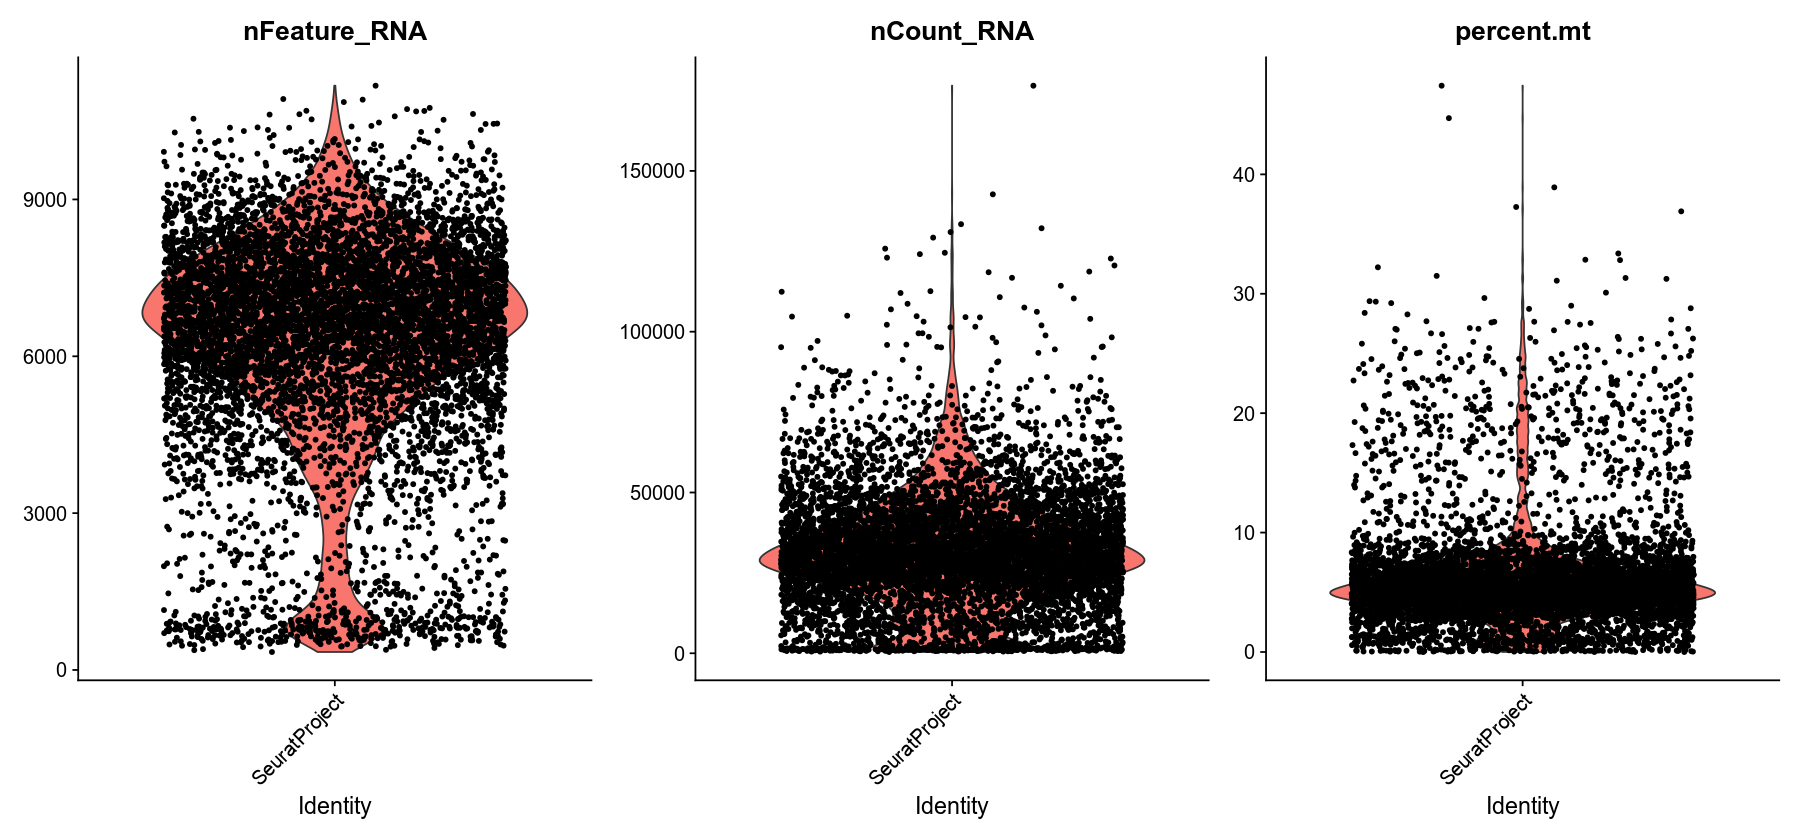

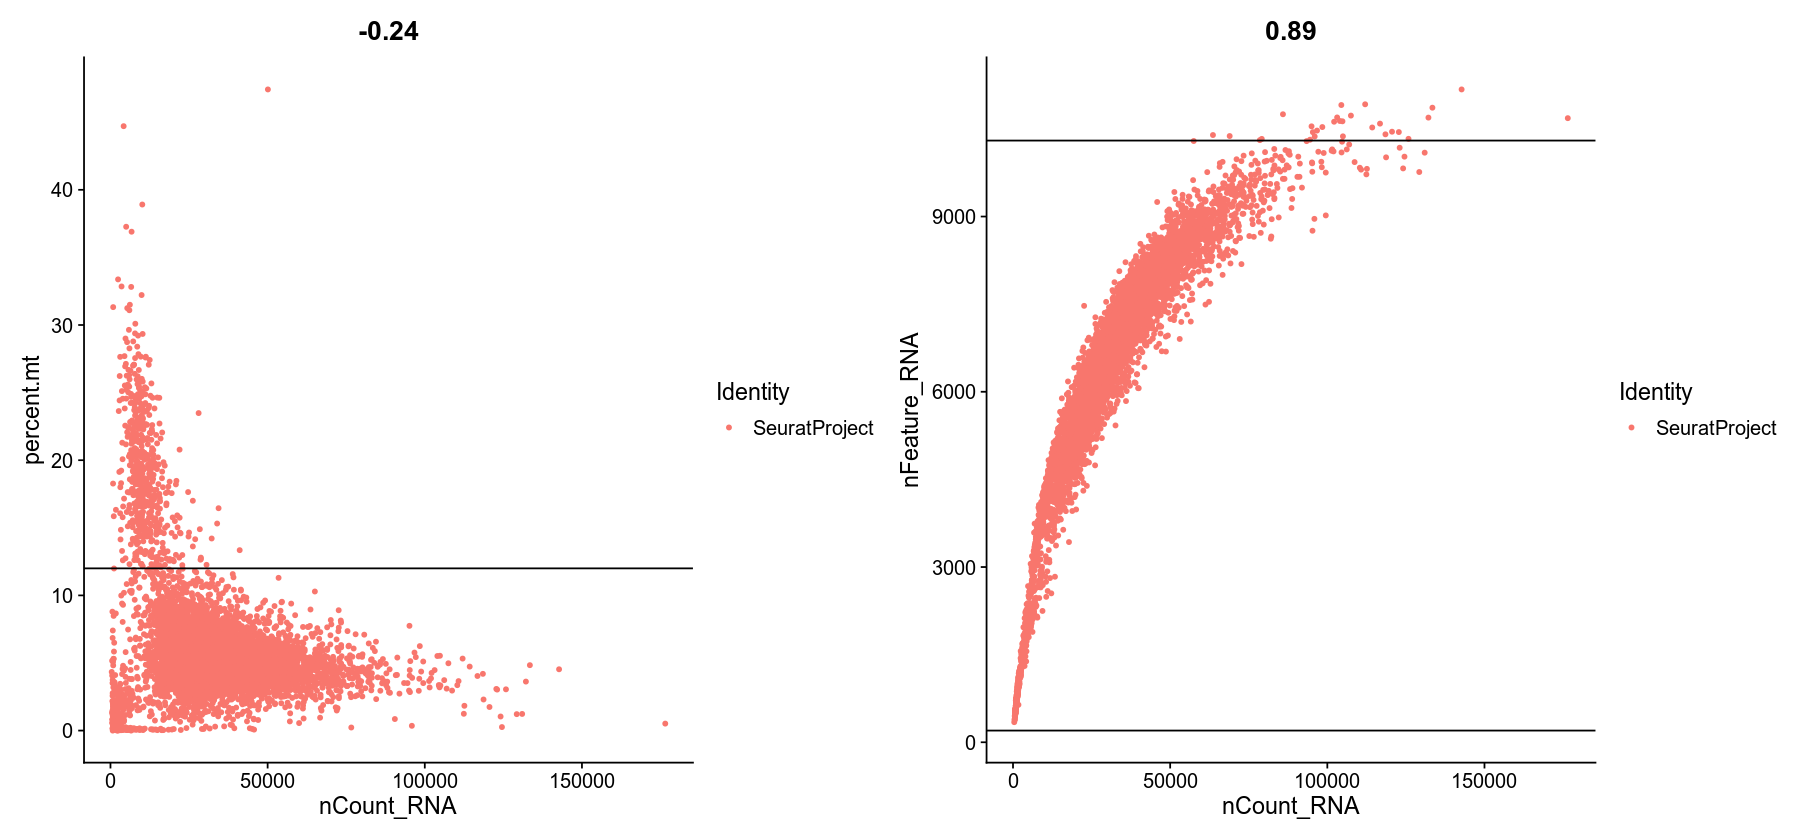

In [12]:
options(repr.plot.width=15, repr.plot.height=7)
CRISPRi_seurat[["percent.mt"]] <- PercentageFeatureSet(CRISPRi_seurat, pattern = "^MT-")
VlnPlot(CRISPRi_seurat, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3)
plot1 <- FeatureScatter(CRISPRi_seurat, feature1 = "nCount_RNA", feature2 = "percent.mt") + geom_hline(yintercept = 12)
plot2 <- FeatureScatter(CRISPRi_seurat, feature1 = "nCount_RNA", feature2 = "nFeature_RNA") + geom_hline(yintercept = 200) + geom_hline(yintercept = 10300)
plot1 + plot2

In [13]:
s.genes <- cc.genes$s.genes
g2m.genes <- cc.genes$g2m.genes
CRISPRi_seurat_with_cc_scores <- CellCycleScoring(CRISPRi_seurat, s.features = s.genes, g2m.features = g2m.genes, set.ident = TRUE)

Warning message:
“The following features are not present in the object: MLF1IP, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: FAM64A, HN1, not searching for symbol synonyms”


In [14]:
CRISPRi_seurat <- NormalizeData(CRISPRi_seurat, normalization.method = 'RC')
## regress CC out of data manually since Seurat requires scaling data in addition


In [15]:
#CRISPRi_seurat <- subset(CRISPRi_seurat, subset = nFeature_RNA > 200 & nFeature_RNA < 10300 & percent.mt < 12)
#suppressWarnings({CRISPRi_seurat <- SCTransform(CRISPRi_seurat, vars.to.regress = "percent.mt", verbose = FALSE)})

In [16]:
c('NT-1i', 'NT-2i', 'NT-3i', 'NT-4i', 'NT-5i', as.character(CRISPRi_guides_to_keep_and_analyze$guide))

[1] "NT-1i"      "NT-2i"      "NT-3i"      "NT-4i"      "NT-5i"     
 [6] "ASF1B-1i"   "AURKA-1i"   "AURKB-1i"   "CDK1-1i"    "CENPM-1i"  
[11] "CENPN-2i"   "ENY2-2i"    "HJURP-2i"   "HMGA1-1i"   "JMJD6-1i"  
[16] "MIS18A-1i"  "NELFE-1i"   "RNF8-1i"    "RUVBL1-1i"  "SUPV3L1-1i"
[21] "VRK1-1i"

In [17]:
## only keep guides that were selected in Identifying_guides_with_high_knockdown.ipynb -- make sure knockdown occurred in these guides
CRISPRi_seurat = CRISPRi_seurat[, CRISPRi_seurat@meta.data$guide %in% c('NT-1i', 'NT-2i', 'NT-3i', 'NT-4i', 'NT-5i', as.character(CRISPRi_guides_to_keep_and_analyze$guide))]
CRISPRi_seurat@meta.data$guide <- stringr::str_sub(CRISPRi_seurat@meta.data$guide, start = 1, end = -4)

In [18]:
filtered_raw_mtx <- CRISPRi_seurat@assays$RNA@data
medians = sparseMatrixStats::rowMedians(filtered_raw_mtx)
median_df = data.frame(gene_medians = medians)

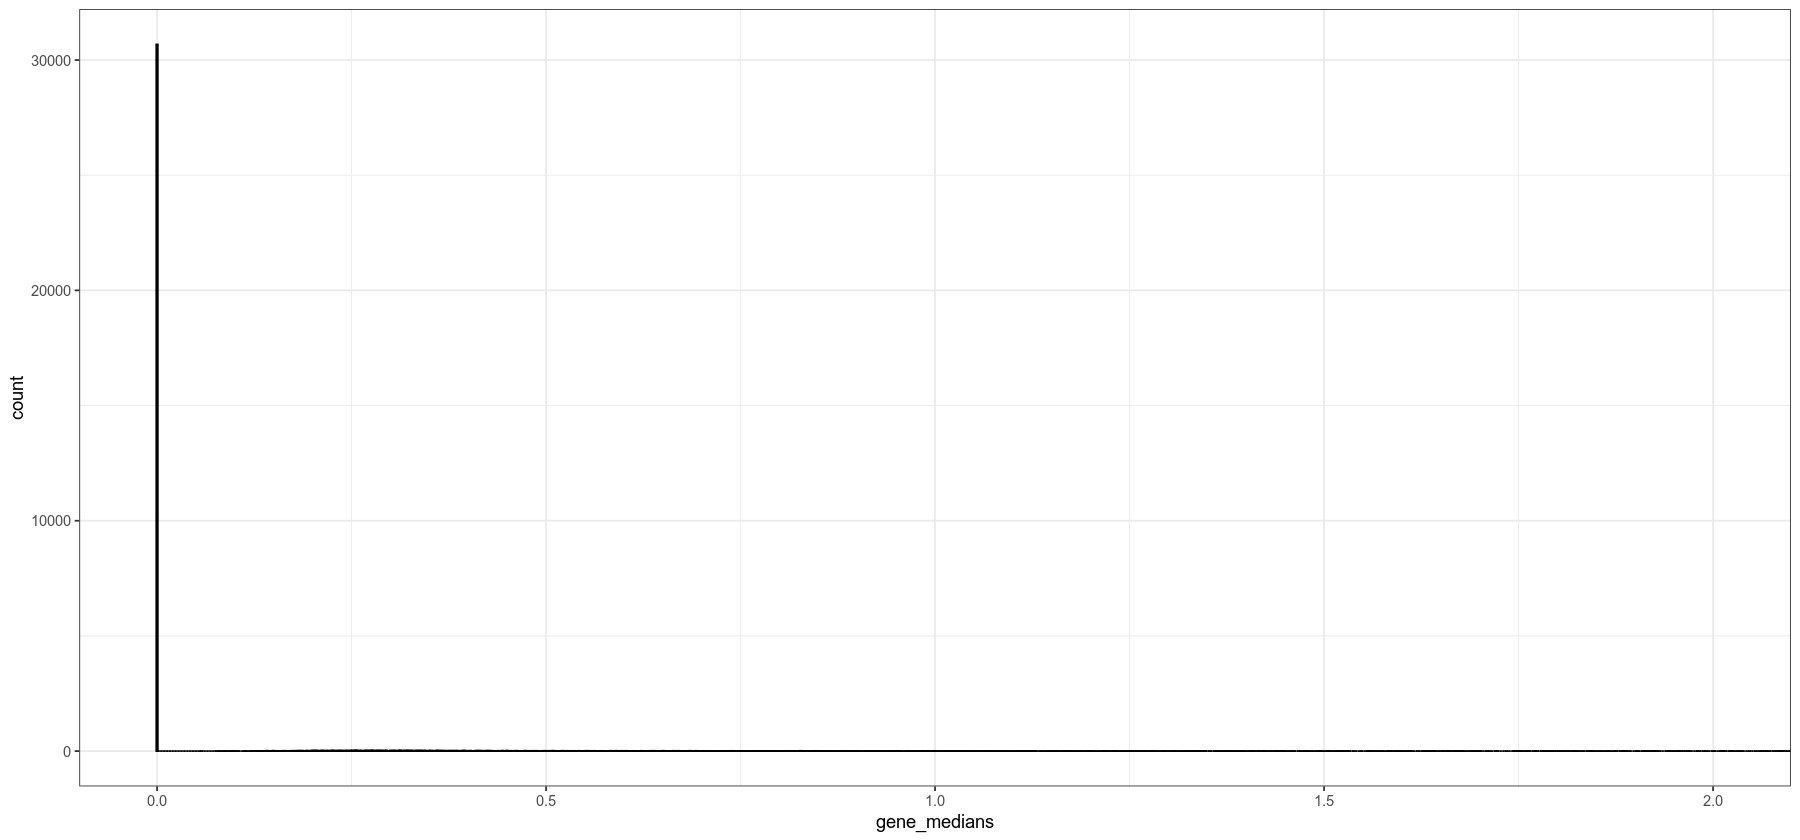

In [19]:
ggplot(median_df, aes(x=gene_medians)) + 
  geom_histogram(color="black", fill="white", bins = 50000) +
  geom_vline(xintercept = 10, color = 'blue') + coord_cartesian(xlim = c(0,2)) +
  theme_bw()

In [20]:
pct_genes_left = function(median_expression, cutoff){
  pct = 100*length(which(median_expression >= cutoff))/length(median_expression)
  return(pct)
}

pct_genes_left(medians, 0.1)

[1] 16.14983

In [21]:
## removing any genes that are not in top 2000 most variable
## filtered_raw_mtx <- filtered_raw_mtx[top_variable_genes,]
##filtered_raw_mtx <- filtered_raw_mtx[top_variable_genes,]
##filtered_meta_data <- filtered_meta_data[colnames(filtered_raw_mtx),]

In [22]:
### removing genes with medians < 0.1 keeps 16% of genes -- low expressing genes have noisy expression and confound results ###
filtered_meta_data <- CRISPRi_seurat@meta.data
genes_to_keep = as.numeric(medians) >= 0.1
filtered_raw_mtx <- CRISPRi_seurat@assays$RNA@data[genes_to_keep,]
filtered_meta_data <- filtered_meta_data[colnames(filtered_raw_mtx),]

used_genes = rownames(filtered_raw_mtx)
path = paste0('/home/ssobti/projects/heterogeneity_brian/output_data/CRISPRi_CRISPRa_cell_culture_screen/heterogeneity/', variant, 'CRISPRi_used_genes.rds')
saveRDS(used_genes, path)

In [23]:
dim(filtered_raw_mtx)

[1] 5911 6975

In [24]:
## cells per guide count
guides = unique(filtered_meta_data$guide)

cells_per_guide = vector()
for (i in 1:length(guides)){
    cells_per_guide[i] = length(which(filtered_meta_data$guide == guides[i]))
}

cell_gd_count = data.frame(guide_name = guides, cell_count = cells_per_guide)

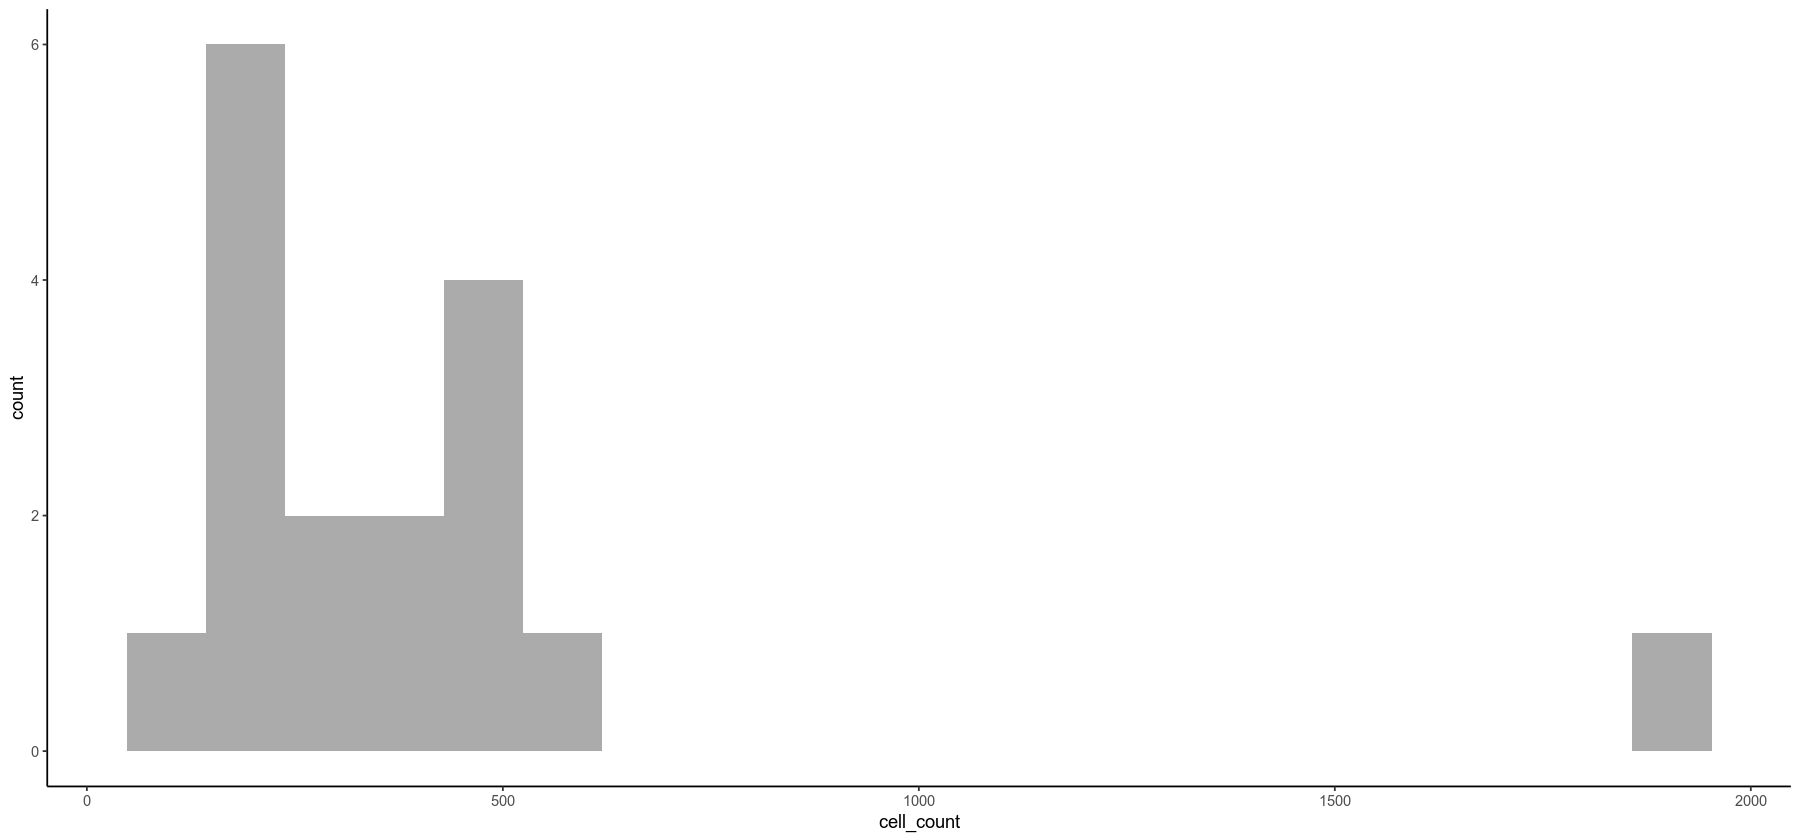

In [25]:
### show distribution of cells per guide

ggplot(cell_gd_count, aes(x=cell_count)) +
geom_histogram(position="identity", alpha=0.5, bins = 20) +
theme_classic()

In [26]:
arrange(cell_gd_count, cell_count)

guide_name,cell_count
<fct>,<int>
AURKB,90
CENPN,187
CDK1,192
HJURP,212
SUPV3L1,216
AURKA,227
ENY2,232
RUVBL1,274
CENPM,328


In [27]:
### divide expression mtx into a list of mtxs subsetted by guide

mtx_subsetter = function(guide_nm, matrix, meta_data){
    return(matrix[, meta_data$guide == guide_nm])}

guide_subsetted_data = pblapply(X = guides, FUN = mtx_subsetter, 
                                matrix = filtered_raw_mtx, meta_data = filtered_meta_data)

names(guide_subsetted_data) = guides

In [28]:
## control number of cells per guide to be equivalent
## throw out guides with < 90 cells and for the remaining guides sample 90 cells without replacement
fixed_cell_count = 90
guide_subsetted_data = guide_subsetted_data[cells_per_guide >= fixed_cell_count]
cells_to_discard = list()

set.seed(22)
for (i in 1:length(guide_subsetted_data)){
    idx_to_keep = sample(1:ncol(guide_subsetted_data[[i]]), fixed_cell_count, replace = FALSE)
    idx_to_discard = setdiff(1:ncol(guide_subsetted_data[[i]]), idx_to_keep)
    cells_to_discard[[i]] = colnames(guide_subsetted_data[[i]])[idx_to_discard]
    guide_subsetted_data[[i]] = guide_subsetted_data[[i]][,idx_to_keep]
}

cells_to_discard = unlist(cells_to_discard)

In [29]:
## add bkg distribution of guide subsetted mtxs to list
## this is just mtxs where the cells are randomly assigned to each guide
## the bkg distribution of mtxs is made to subtract out number of genes that are expected to have increased or decreased CV when cells assigned randomly to each guide
## Note: the number of cells assigned to each guide is kept the same
set.seed(44)

randomized_filtered_raw_mtx = Reduce(cbind, guide_subsetted_data[names(guide_subsetted_data) != "NT"])
randomized_cell_order = sample(colnames(randomized_filtered_raw_mtx), ncol(randomized_filtered_raw_mtx), replace = FALSE)


designation_vector = mapply(rep, guides[guides != 'NT'], fixed_cell_count, SIMPLIFY = TRUE)
designation_vector = unlist(designation_vector)
designation_vector = as.character(designation_vector)
split_barcodes = split(randomized_cell_order, designation_vector)
mtx_random_splitter = function(barcodes, mtx){return(mtx[,barcodes])}

guide_random_subsetted_data = pblapply(X = split_barcodes, FUN = mtx_random_splitter, mtx = randomized_filtered_raw_mtx)
guide_random_subsetted_data = c(guide_subsetted_data[names(guide_subsetted_data) == "NT"], guide_random_subsetted_data)
names(guide_random_subsetted_data) = paste('random', c('NT', guides[guides != 'NT']), sep = '_')
guide_subsetted_data = c(guide_subsetted_data, guide_random_subsetted_data)

In [30]:
## compare each of the guide subsetted data to the control subsetted data and
## create the following table for each guide:
## gene | CV1 (ctrl) | CV2 (gd) | CV2/CV1 | Increasing or Decreasing CV (ie CV2/CV1 > 1 or CV2/CV1 < 1) | asymptotic test p-value | q-value 


## CV calculator
CV_calculator = function(x){return((sparseMatrixStats::rowSds(x))/(sparseMatrixStats::rowMeans2(x)))}
CVs = pblapply(X = guide_subsetted_data, FUN = CV_calculator)
names(CVs) = names(guide_subsetted_data)

In [31]:
### creating first 4 columns of the table annotated above
gene_means = lapply(guide_subsetted_data, sparseMatrixStats::rowMeans2)
gene_sds = lapply(guide_subsetted_data, sparseMatrixStats::rowSds)
names(gene_means) = names(guide_subsetted_data)
names(gene_sds) = names(guide_subsetted_data)


master_df_list = list()
for (i in 1:length(guide_subsetted_data)){
    if (!startsWith(names(guide_subsetted_data)[i], 'random')){
        master_df_list[[i]] = data.frame(gene = rownames(filtered_raw_mtx), CV_ctrl = CVs[['NT']], 
                                         CV_gd = CVs[[i]], CV_gdCV_ctrlratio = CVs[[i]]/CVs[['NT']], mean_gdmean_ctrlratio = gene_means[[i]]/gene_means[['NT']])
        names(master_df_list)[i] <- names(guide_subsetted_data)[i]
    }
    if (startsWith(names(guide_subsetted_data)[i], 'random')){
        master_df_list[[i]] = data.frame(gene = rownames(filtered_raw_mtx), CV_ctrl = CVs[['NT']], 
                                         CV_gd = CVs[[i]], CV_gdCV_ctrlratio = CVs[[i]]/CVs[['NT']], mean_gdmean_ctrlratio = gene_means[[i]]/gene_means[['NT']])
        names(master_df_list)[i] <- names(guide_subsetted_data)[i]
    }
}



In [32]:
### creating column 5 of the table annotated above
for (i in 1:length(master_df_list)){
    master_df_list[[i]]$gene_status = 'NA'
    master_df_list[[i]]$gene_status[master_df_list[[i]]$CV_gdCV_ctrlratio == 1] = 'No Change'
    master_df_list[[i]]$gene_status[master_df_list[[i]]$CV_gdCV_ctrlratio > 1] = 'Increasing'
    master_df_list[[i]]$gene_status[master_df_list[[i]]$CV_gdCV_ctrlratio < 1] = 'Decreasing'               
}


In [33]:
## performing CV equality aysmptotic test and adding its pval to master_df_list
cells_per_guide = rep(cells_per_guide, 2)
names(cells_per_guide) = names(guide_subsetted_data)
asymp_test_p_vals = as.data.frame(matrix(0, nrow = nrow(filtered_raw_mtx), ncol = length(master_df_list)))


for (i in 1:length(master_df_list)){
    if (!startsWith(names(guide_subsetted_data)[i], 'random')){
        for (j in 1:nrow(filtered_raw_mtx)){
            test = asymptotic_test2(k = 2, n = c(cells_per_guide['NT'], cells_per_guide[i]), s = c(gene_sds[['NT']][j], gene_sds[[i]][j]), 
                                    x = c(gene_means[['NT']][j], gene_means[[i]][j]))
            asymp_test_p_vals[j,i] = test$p_value
        }
    }
    if (startsWith(names(guide_subsetted_data)[i], 'random')){
        for (j in 1:nrow(filtered_raw_mtx)){
            test = asymptotic_test2(k = 2, n = c(cells_per_guide['NT'], cells_per_guide[i]), s = c(gene_sds[['NT']][j], gene_sds[[i]][j]), 
                                    x = c(gene_means[['NT']][j], gene_means[[i]][j]))
            asymp_test_p_vals[j,i] = test$p_value
        }    
    }
    master_df_list[[i]]$p_val = asymp_test_p_vals[,i]
}

# saveRDS(master_df_list, paste0('/home/ssobti/projects/heterogeneity_brian/output_data/CRISPRi_CRISPRa_cell_culture_screen/heterogeneity/', variant, 'CV_ratios.rds'))

In [34]:
## ***
## pick relevant assay in FindMarkers
## Find genes that see a significant change in mean from NT control
pbo = pboptions(type="txt")
cells_to_keep_from_fixed_cell_count <- colnames(Reduce(cbind, guide_subsetted_data[guides]))


Idents(object = CRISPRi_seurat) <- CRISPRi_seurat@meta.data$guide
CRISPRi_seurat = CRISPRi_seurat[genes_to_keep, cells_to_keep_from_fixed_cell_count]

find_markers_wrapper = function(perturbed_gene){
                                      FindMarkers(CRISPRi_seurat, ident.1 = 'NT', ident.2 = perturbed_gene, test.use = 't', verbose = FALSE)
}

mean_shifts_from_NT = pblapply(guides[guides != 'NT'], find_markers_wrapper)
names(mean_shifts_from_NT) = guides[guides != 'NT']

## Find genes that see signinficant change in mean from control in bkg (randomized cell labels)

CRISPRi_seurat_random = CRISPRi_seurat
meta_temp = CRISPRi_seurat_random@meta.data
meta_temp[randomized_cell_order, 'guide'] = designation_vector
CRISPRi_seurat_random@meta.data = meta_temp

find_markers_wrapper_random = function(perturbed_gene){
                                      FindMarkers(CRISPRi_seurat_random, ident.1 = 'NT', ident.2 = perturbed_gene, test.use = 't', verbose = FALSE)
}

mean_shifts_from_NT_bkg = pblapply(guides[guides != 'NT'], find_markers_wrapper_random)
names(mean_shifts_from_NT_bkg) = paste('random', sep = '_', guides[guides != 'NT'])

mean_shifts_from_NT = c(mean_shifts_from_NT, mean_shifts_from_NT_bkg)

  |++++++++++++++++++++++++++++++++++++++++++++++++++| 100%
  |++++++++++++++++++++++++++++++++++++++++++++++++++| 100%


## Comparing guide CV and NT guide CV ratios

In [35]:
plotted_guides = names(master_df_list)[!(names(master_df_list) %in% c('NT', 'random_NT'))]
plotted_guides_with_NT = names(master_df_list)
ratios = lapply(names(master_df_list), function(x){master_df_list[[x]]$CV_gdCV_ctrlratio})
names(ratios) = plotted_guides_with_NT
ratios_df <- as.data.frame(do.call(cbind, ratios))
colnames(ratios_df) = names(master_df_list)
ratios_df = ratios_df[, !(colnames(ratios_df) %in% c('NT', 'random_NT'))]
ratios_df = tidyr::pivot_longer(ratios_df, cols = colnames(ratios_df), values_to = 'CV_gdCV_ctrlratio', names_to = 'guide')
order_of_guides = ratios_df %>% group_by(guide) %>% summarize(means = mean(CV_gdCV_ctrlratio)) %>% arrange(means) %>% pull(guide) %>% as.character()
ratios_df$guide = factor(ratios_df$guide, levels = order_of_guides)

In [36]:
ratios = ratios[order_of_guides]
tests = lapply(ratios, t.test, mu = 1)
pvals = as.numeric(lapply(tests, function(x) return(x$p.val)))
pvals_adj = signif(p.adjust(pvals), 4)
pvals_adj[pvals_adj == 0] = '< e-300'

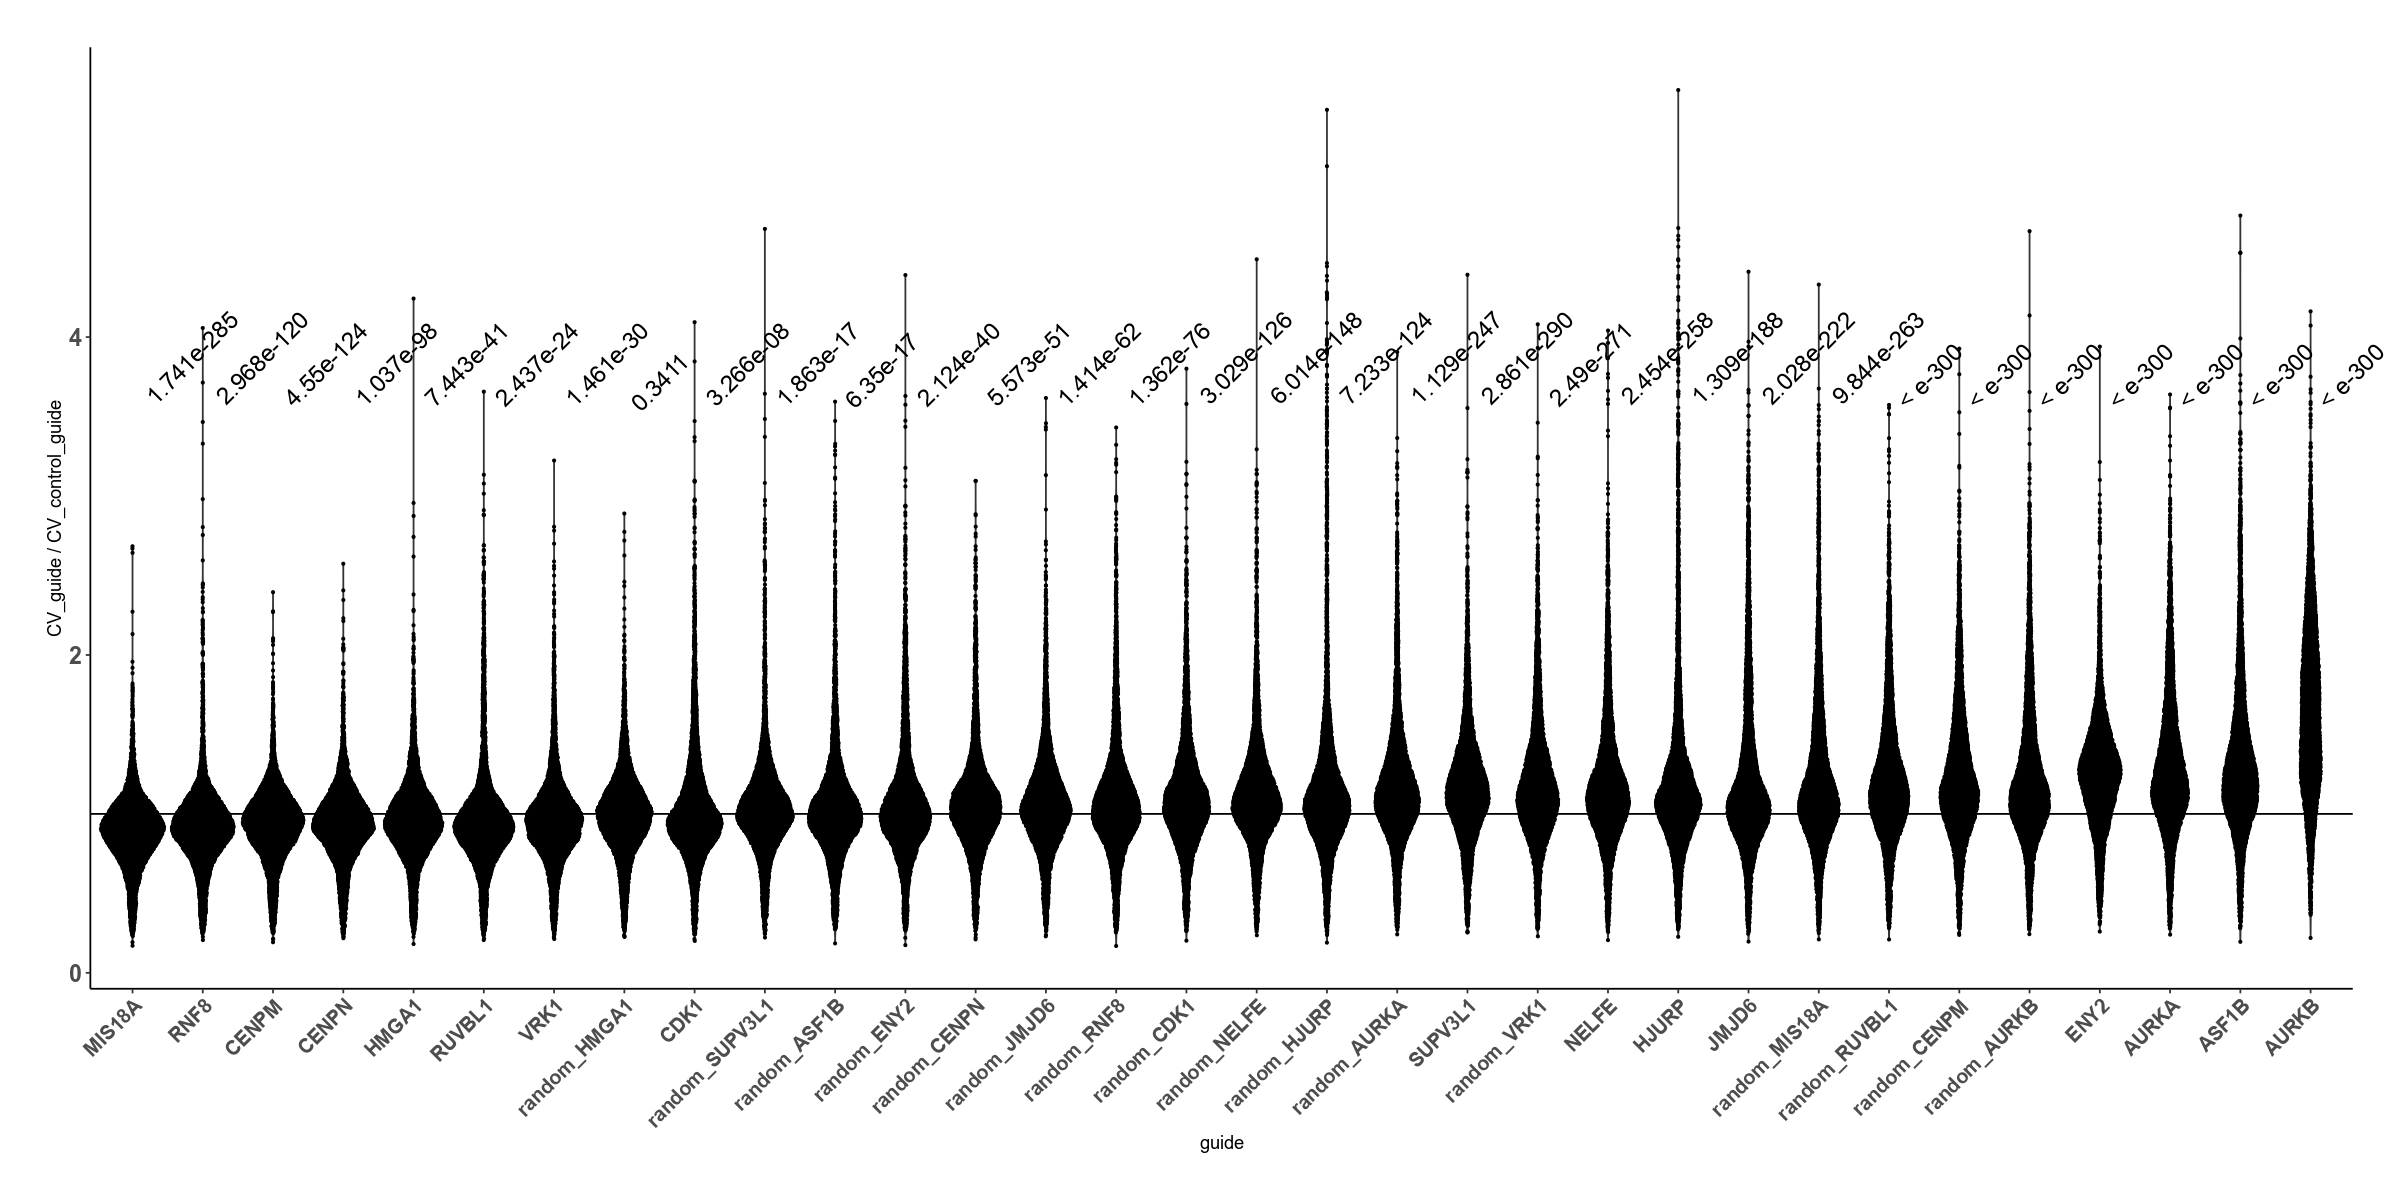

In [37]:
options(repr.plot.width=20, repr.plot.height=10)
library(ggforce)
plotted_guides = names(master_df_list)[!(names(master_df_list) %in% c('NT', 'random_NT'))]
ggplot(ratios_df, aes(guide, CV_gdCV_ctrlratio, fill = guide)) + ylab('CV_guide / CV_control_guide') +
  geom_violin(position=position_dodge()) + annotate("text", x = 1:length(plotted_guides), y = 3.5, size = 5, angle='45', hjust = -0.2, label = pvals_adj) +
  geom_sina(position=position_dodge(), size = 0.5) + geom_hline(yintercept = 1) + coord_cartesian(clip = 'off') +
  theme_classic() + theme(plot.margin = margin(1,1,1,1, "cm"), plot.title = element_text(hjust = 0.5), legend.position = 'none', axis.text.y = element_text(face = 'bold', size = 14), axis.text.x = element_text(face = 'bold', size = 12, angle = 45, hjust = 1))

In [38]:
path = paste0('/home/ssobti/projects/heterogeneity_brian/output_data/CRISPRi_CRISPRa_cell_culture_screen/heterogeneity/', variant, 'violin_CV_ratio.pdf')
ggsave(path, height = 10, width = 20)

In [39]:
plotted_guides = names(master_df_list)[!(names(master_df_list) %in% c('NT', 'random_NT'))]
plotted_guides_with_NT = names(master_df_list)
ratios = lapply(names(master_df_list), function(x){log2(master_df_list[[x]]$CV_gdCV_ctrlratio)})
names(ratios) = plotted_guides_with_NT
ratios_df <- as.data.frame(do.call(cbind, ratios))
colnames(ratios_df) = names(master_df_list)
ratios_df = ratios_df[, !(colnames(ratios_df) %in% c('NT', 'random_NT'))]
ratios_df = tidyr::pivot_longer(ratios_df, cols = colnames(ratios_df), values_to = 'CV_gdCV_ctrlratio', names_to = 'guide')
order_of_guides = ratios_df %>% group_by(guide) %>% summarize(means = mean(CV_gdCV_ctrlratio)) %>% arrange(means) %>% pull(guide) %>% as.character()
ratios_df$guide = factor(ratios_df$guide, levels = order_of_guides)

In [40]:
ratios = ratios[order_of_guides]
tests = lapply(ratios, t.test, mu = 0)
pvals = as.numeric(lapply(tests, function(x) return(x$p.val)))
pvals_adj = signif(p.adjust(pvals), 4)
pvals_adj[pvals_adj == 0] = '< e-300'

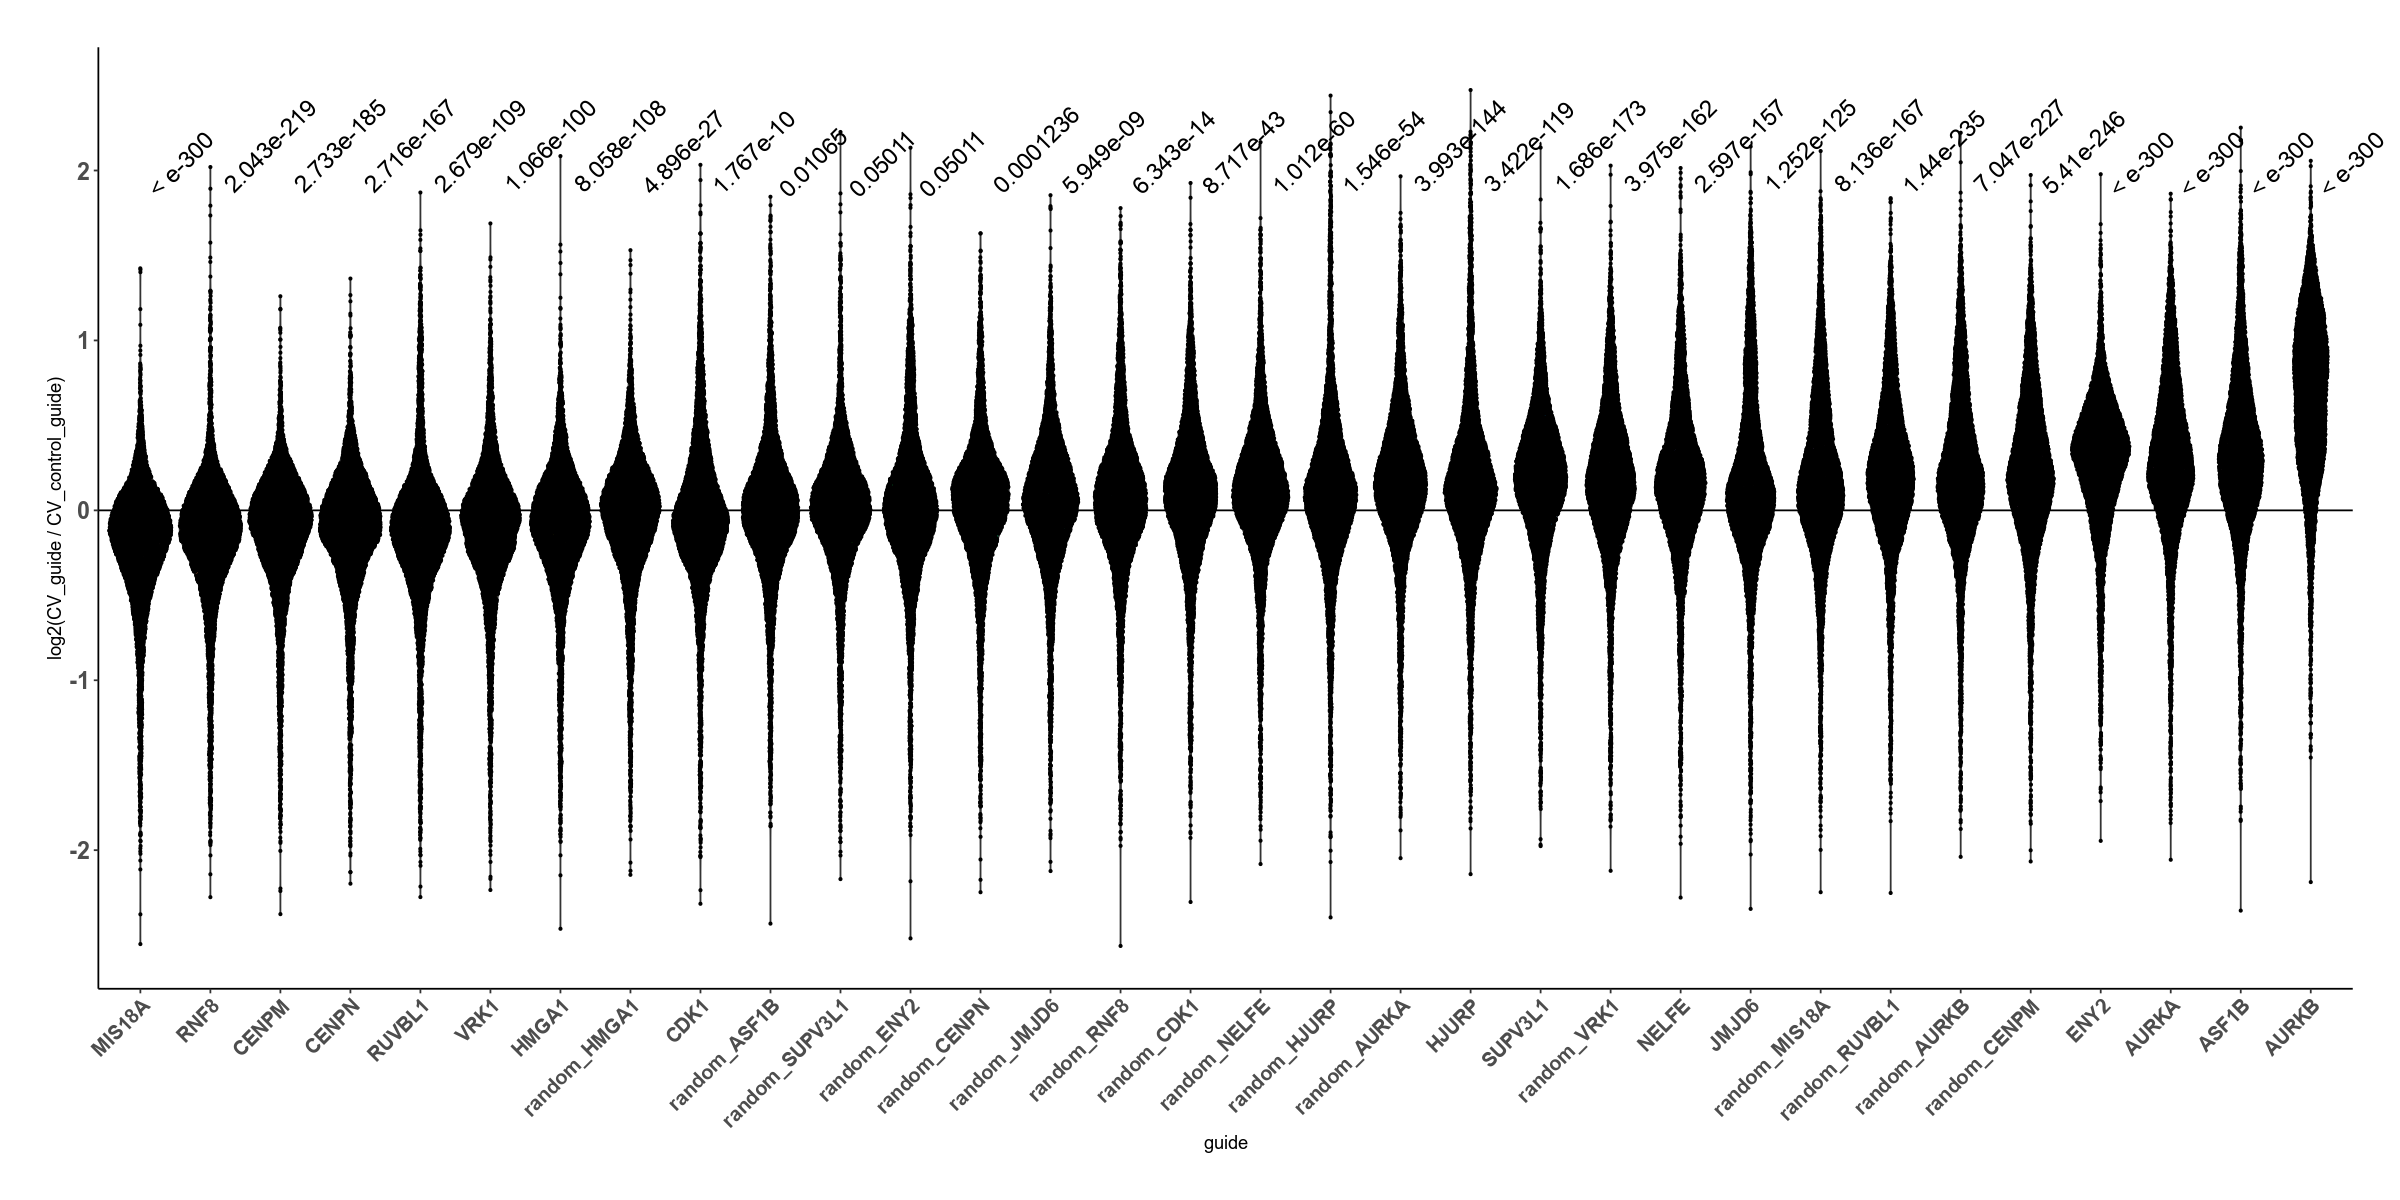

In [41]:
options(repr.plot.width=20, repr.plot.height=10)
library(ggforce)
saveRDS(ratios_df, '/home/ssobti/projects/heterogeneity_brian/fig_output/data/fig3/crispri_single_cell_violin_df.rds')
saveRDS(pvals_adj, '/home/ssobti/projects/heterogeneity_brian/fig_output/data/fig3/crispri_single_cell_pvals.rds')
saveRDS(plotted_guides, '/home/ssobti/projects/heterogeneity_brian/fig_output/data/fig3/crispri_single_cell_guides.rds')
ggplot(ratios_df, aes(guide, CV_gdCV_ctrlratio, fill = guide)) + ylab('log2(CV_guide / CV_control_guide)') +
  geom_violin(position=position_dodge()) + annotate("text", x = 1:length(plotted_guides), y = 1.8, size = 5, angle='45', hjust = -0.2, label = pvals_adj) +
  geom_sina(position=position_dodge(), size = 0.5) + geom_hline(yintercept = 0) + coord_cartesian(clip = 'off') +
  theme_classic() + theme(plot.margin = margin(1,1,1,1, "cm"), plot.title = element_text(hjust = 0.5), legend.position = 'none', axis.text.y = element_text(face = 'bold', size = 14), axis.text.x = element_text(face = 'bold', size = 12, angle = 45, hjust = 1)) 

In [42]:
path = paste0('/home/ssobti/projects/heterogeneity_brian/output_data/CRISPRi_CRISPRa_cell_culture_screen/heterogeneity/', variant, 'violin_CV_ratio_log2.pdf')
ggsave(path, height = 10, width = 20)

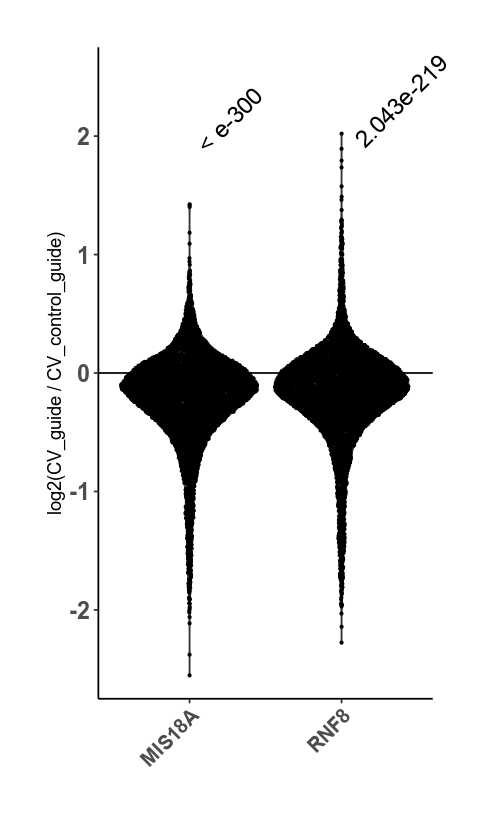

In [43]:
options(repr.plot.width = 4, repr.plot.height = 7)
ratios_df %>% dplyr::filter(guide %in% c('MIS18A', 'RNF8')) %>% ggplot(aes(guide, CV_gdCV_ctrlratio, fill = guide)) + ylab('log2(CV_guide / CV_control_guide)') +
  geom_violin(position=position_dodge()) + annotate("text", x = 1:2, y = 1.8, size = 5, angle='45', hjust = -0.2, label = pvals_adj[1:2]) + xlab('') +
  geom_sina(position=position_dodge(), size = 0.5) + geom_hline(yintercept = 0) + coord_cartesian(clip = 'off', ylim = c(-2.5,2.5)) +
  theme_classic() + theme(plot.margin = margin(1,1,1,1, "cm"), plot.title = element_text(hjust = 0.5), legend.position = 'none', axis.text.y = element_text(face = 'bold', size = 14), axis.text.x = element_text(face = 'bold', size = 12, angle = 45, hjust = 1)) 

In [44]:
## ks.test volcano plot for CV guide vs CV control guide -- KS test is better than Chi-square test for this data
ks.tests = lapply(CVs[!names(CVs) %in% c('NT', 'random_NT')], ks.test, y = CVs[['NT']])
ks.tests.pvals = lapply(ks.tests, function(x) return(x$p.value))
ks.tests.pvals_adj = signif(p.adjust(ks.tests.pvals), 4)
ks.tests.pvals_adj[ks.tests.pvals_adj == 0] = 10^-50
ks.tests.pvals_adj

NELFE         MIS18A        SUPV3L1           CDK1           VRK1 
     1.000e-50      1.000e-50      1.000e-50      1.436e-05      1.000e-50 
         JMJD6          HMGA1          HJURP          CENPM           RNF8 
     1.000e-50      1.000e-50      1.000e-50      1.000e-50      1.000e-50 
          ENY2          CENPN          ASF1B          AURKA         RUVBL1 
     1.000e-50      1.000e-50      1.000e-50      1.000e-50      1.000e-50 
         AURKB   random_NELFE  random_MIS18A random_SUPV3L1    random_CDK1 
     1.000e-50      1.000e-50      1.000e-50      7.238e-02      1.000e-50 
   random_VRK1   random_JMJD6   random_HMGA1   random_HJURP   random_CENPM 
     1.000e-50      4.079e-08      1.039e-03      1.000e-50      1.000e-50 
   random_RNF8    random_ENY2   random_CENPN   random_ASF1B   random_AURKA 
     1.949e-07      7.079e-02      2.646e-06      6.202e-01      1.000e-50 
 random_RUVBL1   random_AURKB 
     1.000e-50      1.000e-50

### Testing for cell cycle effects ###

In [45]:
## show G2M and S phase scores for cells in control vs MIS18A vs RNF8
selected_guides_data = guide_subsetted_data[c('NT', 'MIS18A', 'RNF8')]
col_sizes = sapply(selected_guides_data, ncol)
selected_guides_names = unlist(mapply(FUN = function(x, y) rep(x, y), x = c('NT', 'MIS18A', 'RNF8'), y = col_sizes, SIMPLIFY = FALSE))
select_guide_ids = lapply(selected_guides_data, colnames)
select_guide_ids = unlist(select_guide_ids)
cc_df = data.frame(guide = selected_guides_names, cell_names = select_guide_ids)
cc_df = cbind(cc_df, CRISPRi_seurat_with_cc_scores@meta.data[select_guide_ids, c('S.Score', 'G2M.Score')])
rownames(cc_df) = NULL
cc_df = cc_df %>% tidyr::pivot_longer(cols = c('S.Score', 'G2M.Score'), names_to = 'cycle', values_to = 'score') 
cc_df$guide = factor(cc_df$guide, levels = c('NT', 'MIS18A', 'RNF8'))
cc_df$cycle = factor(cc_df$cycle, levels = c('S.Score', 'G2M.Score'))

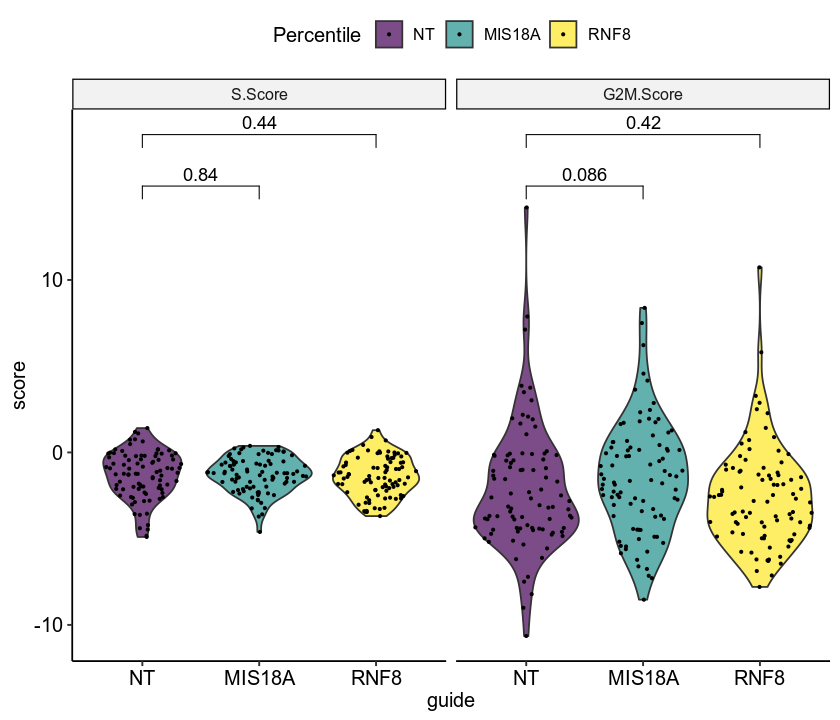

In [46]:
options(repr.plot.width=7, repr.plot.height=6)
## please adjust p-values for multiple hypothesis testing
saveRDS(cc_df, '/home/ssobti/projects/heterogeneity_brian/fig_output/data/fig3/crispri_single_cell_cc_df.rds')

cc_df %>% ggplot(aes(x = guide, y = score, fill = guide)) + geom_violin(position=position_dodge()) + 
  geom_sina(position=position_dodge(), size = 0.5) + scale_fill_viridis_d(alpha = 0.7, name = 'Percentile') +
  facet_wrap(~cycle) + stat_compare_means(comparisons = list(c('NT', 'MIS18A'), c('NT', 'RNF8')), method = 'wilcox.test') + theme_pubr()

### Graphing whole transcriptome CV differences and representative genes ###

#### RNF8 ####

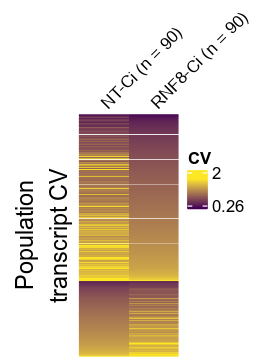

In [50]:
lower_RNF8 = master_df_list[['RNF8']] %>% filter(CV_gdCV_ctrlratio < 1) %>% select(CV_ctrl, CV_gd) %>% arrange(CV_gd)
upper_RNF8 = master_df_list[['RNF8']] %>% filter(CV_gdCV_ctrlratio > 1) %>% select(CV_ctrl, CV_gd) %>% arrange(CV_ctrl)
RNF8_Ci_df = rbind(lower_RNF8, upper_RNF8) %>% as.matrix()
colnames(RNF8_Ci_df) = c('NT-Ci (n = 90)', 'RNF8-Ci (n = 90)')

saveRDS(RNF8_Ci_df, '/home/ssobti/projects/heterogeneity_brian/fig_output/data/fig3/RNF8_Ci_CV_htmp_df.rds')
saveRDS(lower_RNF8, '/home/ssobti/projects/heterogeneity_brian/fig_output/data/fig3/RNF8_Ci_CV_lower.rds')
saveRDS(upper_RNF8, '/home/ssobti/projects/heterogeneity_brian/fig_output/data/fig3/RNF8_Ci_CV_upper.rds')

set.seed(20)
coloring_map <- circlize::colorRamp2(c(0.26, 1.6), scales::viridis_pal(option = 'D')(5)[c(1,5)])

perturb_perturb_corr_mtx_htmp <- function(matrix, title) {
  draw(Heatmap(matrix, name = title, show_column_names = TRUE, show_row_names = FALSE, show_column_dend = FALSE,
               col = coloring_map, show_row_dend = FALSE, use_raster = TRUE, row_title = 'Population\ntranscript CV', 
              row_title_side = 'left', column_title_side = 'top', column_names_side = 'top',
               column_names_gp = gpar(fontsize = 10), row_names_gp = gpar(fontsize = 1), column_names_rot = 45,
               cluster_rows = FALSE, cluster_columns = FALSE, heatmap_legend_param = list(title = "CV", at = c(0.26, 2))), padding = unit(c(2, 2, 2, 12), "pt"))
}


options(repr.plot.width = 2.2, repr.plot.height = 3)
perturb_perturb_corr_mtx_htmp(RNF8_Ci_df)

In [49]:
paste('Percent genes with lower CV than control (top half):', round(100*nrow(lower_RNF8)/nrow(RNF8_Ci_df), 2), '%')
paste('Percent genes with higher CV than control (bottom half):', round(100*nrow(upper_RNF8)/nrow(RNF8_Ci_df), 2), '%')
paste('Mean CV (control):', mean(RNF8_Ci_df[,1]))
paste('Mean CV (RNF8):', mean(RNF8_Ci_df[,2]))
paste('P-value paired t-test:', signif(t.test(RNF8_Ci_df[,1], RNF8_Ci_df[,2], paired = TRUE)$p.value, 3))

[1] "Percent genes with lower CV than control (top half): 68.96 %"

[1] "Percent genes with higher CV than control (bottom half): 31.04 %"

[1] "Mean CV (control): 1.09675060248231"

[1] "Mean CV (RNF8): 0.952551162546552"

[1] "P-value paired t-test: 1.09e-135"

Warning message:
“`fun.y` is deprecated. Use `fun` instead.”
Warning message:
“`fun.y` is deprecated. Use `fun` instead.”
Warning message:
“`fun.y` is deprecated. Use `fun` instead.”
Warning message:
“`fun.y` is deprecated. Use `fun` instead.”


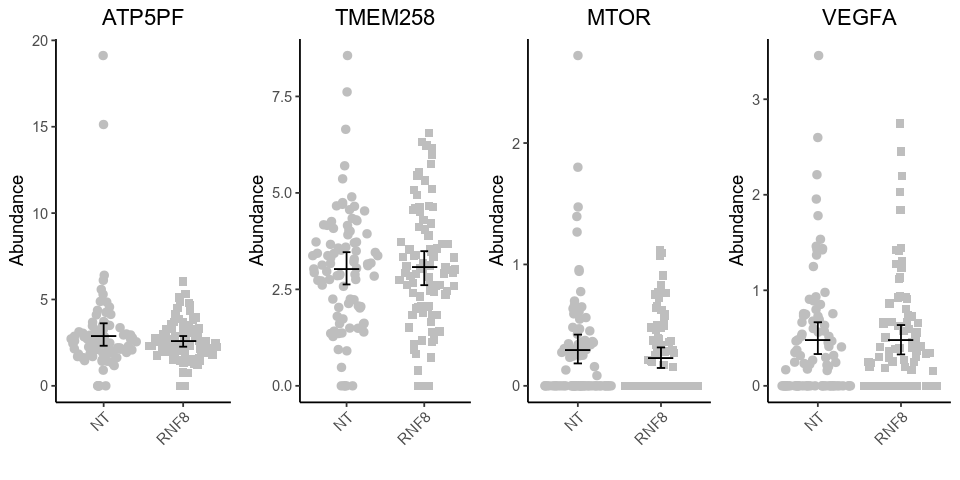

In [51]:
goi = 'ATP5PF'
RNF8_Ci_df = data.frame(NT = guide_subsetted_data[['NT']][goi,], RNF8 = guide_subsetted_data[['RNF8']][goi,])
RNF8_Ci_df = RNF8_Ci_df %>% tidyr::pivot_longer(cols = everything(), names_to = 'guide', values_to = 'expression')
ATP5PF = ggplot(RNF8_Ci_df, aes(guide, expression, shape = guide)) + geom_sina(size = 2, color = 'grey') + theme_classic() + scale_shape_manual(values=c(19, 15)) +
stat_summary(fun.data = mean_cl_boot, geom = "errorbar", width = 0.1, fun.args=list(conf.int = 0.99)) + stat_summary(fun.y = mean, geom = "point", size = 5, shape = '\U2014') + #scale_y_continuous(trans='log10', breaks = c(1, 10^0.5, 10),labels = scales::trans_format("log10", scales::math_format(10^.x))) +
 theme(legend.position = 'none', plot.title = element_text(hjust = 0.5), axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1)) + ylab('Abundance') + xlab('') + ggtitle(goi)
saveRDS(RNF8_Ci_df, '/home/ssobti/projects/heterogeneity_brian/fig_output/data/fig3/ATP5PF_df.rds')


goi = 'TMEM258'
RNF8_Ci_df = data.frame(NT = guide_subsetted_data[['NT']][goi,], RNF8 = guide_subsetted_data[['RNF8']][goi,])
RNF8_Ci_df = RNF8_Ci_df %>% tidyr::pivot_longer(cols = everything(), names_to = 'guide', values_to = 'expression')
TMEM258 = ggplot(RNF8_Ci_df, aes(guide, expression, shape = guide)) + geom_sina(size = 2, color = 'grey') + theme_classic() + scale_shape_manual(values=c(19, 15)) +
stat_summary(fun.data = mean_cl_boot, geom = "errorbar", width = 0.1, fun.args=list(conf.int = 0.99)) + stat_summary(fun.y = mean, geom = "point", size = 5, shape = '\U2014') + #scale_y_continuous(trans='log10', breaks = c(1, 10^0.5, 10),labels = scales::trans_format("log10", scales::math_format(10^.x))) +
 theme(legend.position = 'none', plot.title = element_text(hjust = 0.5), axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1)) + ylab('Abundance') + xlab('') + ggtitle(goi)

saveRDS(RNF8_Ci_df, '/home/ssobti/projects/heterogeneity_brian/fig_output/data/fig3/TMEM258_df.rds')

## controversial
goi = 'MTOR'
RNF8_Ci_df = data.frame(NT = guide_subsetted_data[['NT']][goi,], RNF8 = guide_subsetted_data[['RNF8']][goi,])
RNF8_Ci_df = RNF8_Ci_df %>% tidyr::pivot_longer(cols = everything(), names_to = 'guide', values_to = 'expression')
MTOR = ggplot(RNF8_Ci_df, aes(guide, expression, shape = guide)) + geom_sina(size = 2, color = 'grey') + theme_classic() + scale_shape_manual(values=c(19, 15)) +
stat_summary(fun.data = mean_cl_boot, geom = "errorbar", width = 0.1, fun.args=list(conf.int = 0.99)) + stat_summary(fun.y = mean, geom = "point", size = 5, shape = '\U2014') + #scale_y_continuous(trans='log10', breaks = c(1, 10^0.5, 10),labels = scales::trans_format("log10", scales::math_format(10^.x))) +
 theme(legend.position = 'none', plot.title = element_text(hjust = 0.5), axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1)) + ylab('Abundance') + xlab('') + ggtitle(goi)
saveRDS(RNF8_Ci_df, '/home/ssobti/projects/heterogeneity_brian/fig_output/data/fig3/MTOR_df.rds')

## controversial
goi = 'VEGFA'
RNF8_Ci_df = data.frame(NT = guide_subsetted_data[['NT']][goi,], RNF8 = guide_subsetted_data[['RNF8']][goi,])
RNF8_Ci_df = RNF8_Ci_df %>% tidyr::pivot_longer(cols = everything(), names_to = 'guide', values_to = 'expression')
VEGFA = ggplot(RNF8_Ci_df, aes(guide, expression, shape = guide)) + geom_sina(size = 2, color = 'grey') + theme_classic() + scale_shape_manual(values=c(19, 15)) +
stat_summary(fun.data = mean_cl_boot, geom = "errorbar", width = 0.1, fun.args=list(conf.int = 0.99)) + stat_summary(fun.y = mean, geom = "point", size = 5, shape = '\U2014') + #scale_y_continuous(trans='log10', breaks = c(1, 10^0.5, 10),labels = scales::trans_format("log10", scales::math_format(10^.x))) +
 theme(legend.position = 'none', plot.title = element_text(hjust = 0.5), axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1)) + ylab('Abundance') + xlab('') + ggtitle(goi)
saveRDS(RNF8_Ci_df, '/home/ssobti/projects/heterogeneity_brian/fig_output/data/fig3/VEGFA_df.rds')

options(repr.plot.width = 8, repr.plot.height = 4)
ggarrange(ATP5PF, TMEM258, MTOR, VEGFA, nrow = 1)

#### MIS18A ####

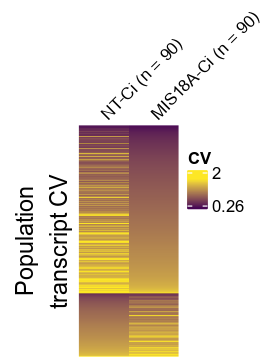

In [52]:
lower_MIS18A = master_df_list[['MIS18A']] %>% filter(CV_gdCV_ctrlratio < 1) %>% select(CV_ctrl, CV_gd) %>% arrange(CV_gd)
upper_MIS18A = master_df_list[['MIS18A']] %>% filter(CV_gdCV_ctrlratio > 1) %>% select(CV_ctrl, CV_gd) %>% arrange(CV_ctrl)
MIS18A_Ci_df = rbind(lower_MIS18A, upper_MIS18A) %>% as.matrix()
colnames(MIS18A_Ci_df) = c('NT-Ci (n = 90)', 'MIS18A-Ci (n = 90)')

saveRDS(MIS18A_Ci_df, '/home/ssobti/projects/heterogeneity_brian/fig_output/data/fig3/MIS18A_Ci_CV_htmp_df.rds')
saveRDS(lower_MIS18A, '/home/ssobti/projects/heterogeneity_brian/fig_output/data/fig3/MIS18A_Ci_CV_lower.rds')
saveRDS(upper_MIS18A, '/home/ssobti/projects/heterogeneity_brian/fig_output/data/fig3/MIS18A_Ci_CV_upper.rds')

set.seed(20)
coloring_map <- circlize::colorRamp2(c(0.24, 1.6), scales::viridis_pal(option = 'D')(5)[c(1,5)])

perturb_perturb_corr_mtx_htmp <- function(matrix, title) {
  draw(Heatmap(matrix, name = title, show_column_names = TRUE, show_row_names = FALSE, show_column_dend = FALSE,
               col = coloring_map, show_row_dend = FALSE, use_raster = TRUE, row_title = 'Population\ntranscript CV', 
              row_title_side = 'left', column_title_side = 'top', column_names_side = 'top',
               column_names_gp = gpar(fontsize = 10), row_names_gp = gpar(fontsize = 1), column_names_rot = 45,
               cluster_rows = FALSE, cluster_columns = FALSE, heatmap_legend_param = list(title = "CV", at = c(0.26, 2))), padding = unit(c(2, 2, 2, 12), "pt"))
}


options(repr.plot.width = 2.2, repr.plot.height = 3)
perturb_perturb_corr_mtx_htmp(MIS18A_Ci_df)

In [53]:
paste('Percent genes with lower CV than control (top half):', round(100*nrow(lower_MIS18A)/nrow(MIS18A_Ci_df), 2), '%')
paste('Percent genes with higher CV than control (bottom half):', round(100*nrow(upper_MIS18A)/nrow(MIS18A_Ci_df), 2), '%')
paste('Mean CV (control):', mean(MIS18A_Ci_df[,1]))
paste('Mean CV (MIS18A):', mean(MIS18A_Ci_df[,2]))
paste('P-value paired t-test:', signif(t.test(MIS18A_Ci_df[,1], MIS18A_Ci_df[,2], paired = TRUE)$p.value, 3))

[1] "Percent genes with lower CV than control (top half): 72.63 %"

[1] "Percent genes with higher CV than control (bottom half): 27.37 %"

[1] "Mean CV (control): 1.09675060248231"

[1] "Mean CV (MIS18A): 0.926295894513471"

[1] "P-value paired t-test: 5.04e-208"

Warning message:
“`fun.y` is deprecated. Use `fun` instead.”
Warning message:
“`fun.y` is deprecated. Use `fun` instead.”
Warning message:
“`fun.y` is deprecated. Use `fun` instead.”


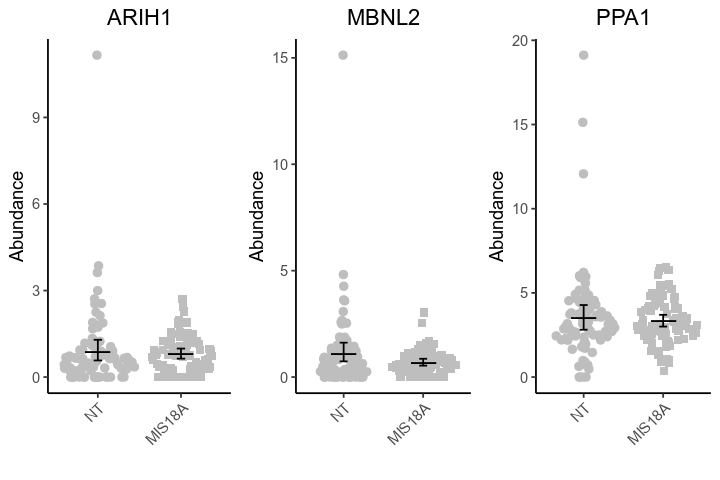

In [54]:
goi = 'ARIH1'
MIS18A_Ci_df = data.frame(NT = guide_subsetted_data[['NT']][goi,], MIS18A = guide_subsetted_data[['MIS18A']][goi,])
MIS18A_Ci_df = MIS18A_Ci_df %>% tidyr::pivot_longer(cols = everything(), names_to = 'guide', values_to = 'expression')
MIS18A_Ci_df$guide = factor(MIS18A_Ci_df$guide, levels = c('NT', 'MIS18A'))
ARIH1 = ggplot(MIS18A_Ci_df, aes(guide, expression, shape = guide)) + geom_sina(size = 2, color = 'grey') + theme_classic() + scale_shape_manual(values=c(19, 15)) +
stat_summary(fun.data = mean_cl_boot, geom = "errorbar", width = 0.1, fun.args=list(conf.int = 0.99)) + stat_summary(fun.y = mean, geom = "point", size = 5, shape = '\U2014') + #scale_y_continuous(trans='log10', breaks = c(1, 10^0.5, 10),labels = scales::trans_format("log10", scales::math_format(10^.x))) +
 theme(legend.position = 'none', plot.title = element_text(hjust = 0.5), axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1)) + ylab('Abundance') + xlab('') + ggtitle(goi)
saveRDS(MIS18A_Ci_df, '/home/ssobti/projects/heterogeneity_brian/fig_output/data/fig3/ARIH1_df.rds')

goi = 'MBNL2'
MIS18A_Ci_df = data.frame(NT = guide_subsetted_data[['NT']][goi,], MIS18A = guide_subsetted_data[['MIS18A']][goi,])
MIS18A_Ci_df = MIS18A_Ci_df %>% tidyr::pivot_longer(cols = everything(), names_to = 'guide', values_to = 'expression')
MIS18A_Ci_df$guide = factor(MIS18A_Ci_df$guide, levels = c('NT', 'MIS18A'))
MBNL2 = ggplot(MIS18A_Ci_df, aes(guide, expression, shape = guide)) + geom_sina(size = 2, color = 'grey') + theme_classic() + scale_shape_manual(values=c(19, 15)) +
stat_summary(fun.data = mean_cl_boot, geom = "errorbar", width = 0.1, fun.args=list(conf.int = 0.99)) + stat_summary(fun.y = mean, geom = "point", size = 5, shape = '\U2014') + #scale_y_continuous(trans='log10', breaks = c(1, 10^0.5, 10),labels = scales::trans_format("log10", scales::math_format(10^.x))) +
 theme(legend.position = 'none', plot.title = element_text(hjust = 0.5), axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1)) + ylab('Abundance') + xlab('') + ggtitle(goi)
saveRDS(MIS18A_Ci_df, '/home/ssobti/projects/heterogeneity_brian/fig_output/data/fig3/MBNL2_df.rds')

goi = 'PPA1'
MIS18A_Ci_df = data.frame(NT = guide_subsetted_data[['NT']][goi,], MIS18A = guide_subsetted_data[['MIS18A']][goi,])
MIS18A_Ci_df = MIS18A_Ci_df %>% tidyr::pivot_longer(cols = everything(), names_to = 'guide', values_to = 'expression')
MIS18A_Ci_df$guide = factor(MIS18A_Ci_df$guide, levels = c('NT', 'MIS18A'))
PPA1 = ggplot(MIS18A_Ci_df, aes(guide, expression, shape = guide)) + geom_sina(size = 2, color = 'grey') + theme_classic() + scale_shape_manual(values=c(19, 15)) +
stat_summary(fun.data = mean_cl_boot, geom = "errorbar", width = 0.1, fun.args=list(conf.int = 0.99)) + stat_summary(fun.y = mean, geom = "point", size = 5, shape = '\U2014') + #scale_y_continuous(trans='log10', breaks = c(1, 10^0.5, 10),labels = scales::trans_format("log10", scales::math_format(10^.x))) +
 theme(legend.position = 'none', plot.title = element_text(hjust = 0.5), axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1)) + ylab('Abundance') + xlab('') + ggtitle(goi)
saveRDS(MIS18A_Ci_df, '/home/ssobti/projects/heterogeneity_brian/fig_output/data/fig3/PPA1_df.rds')

options(repr.plot.width = 6, repr.plot.height = 4)
ggarrange(ARIH1, MBNL2, PPA1, nrow = 1)

#### Volcano Plot of average CV shifts ####

In [204]:
library(EnhancedVolcano)
CV_ratio_means = as.numeric(lapply(ratios, function(x) return(mean(x))))
volcano_df = data.frame(CV_ratio_means, ks.tests.pvals_adj = ks.tests.pvals_adj[names(ratios)], guides = names(ratios))

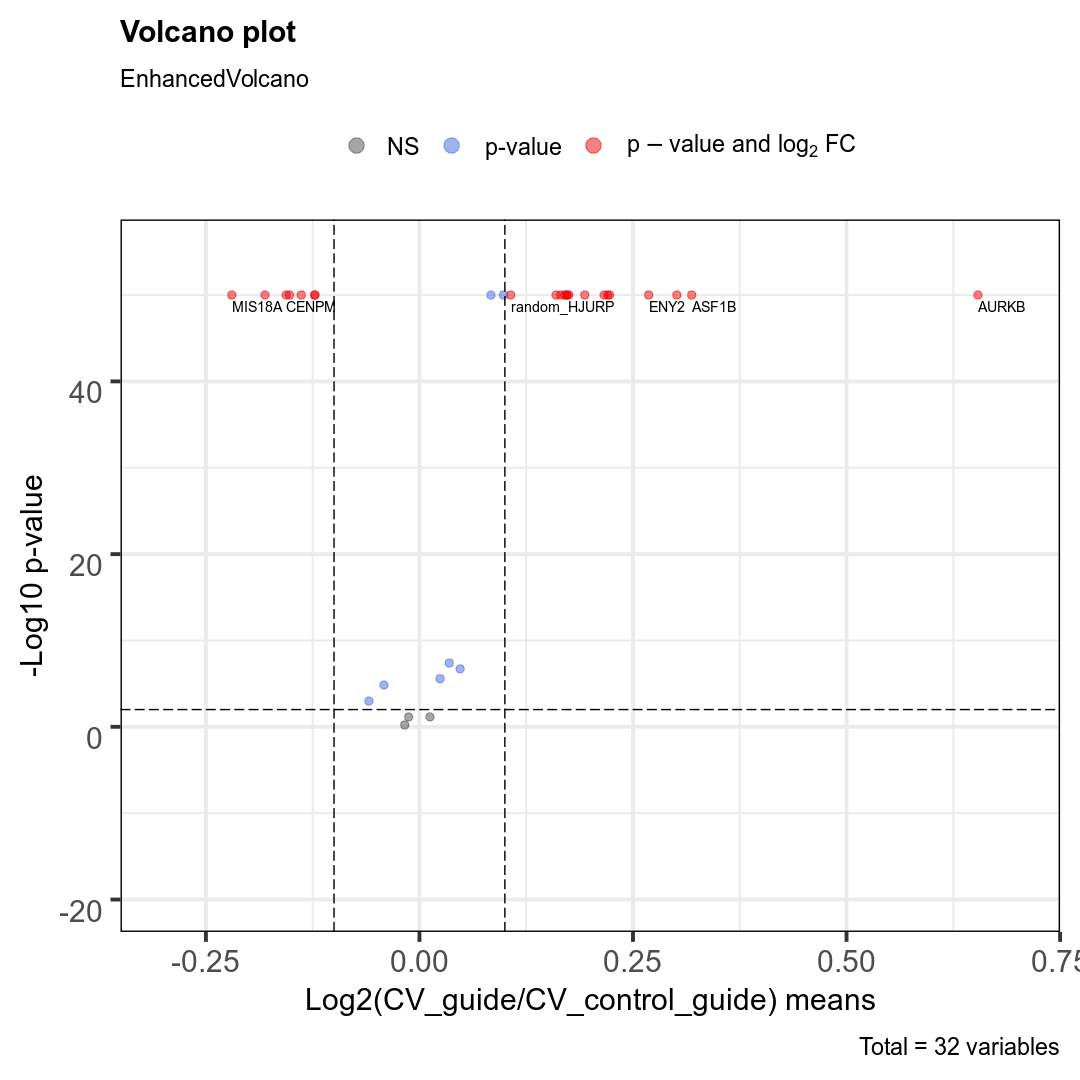

In [208]:
## volcano plot showing Log2(CV_guide/CV_control_guide) means vs ks.test p-values
options(repr.plot.width=9, repr.plot.height=9)
EnhancedVolcano(volcano_df, lab = volcano_df$guides, x = 'CV_ratio_means', xlab = 'Log2(CV_guide/CV_control_guide) means', 
y = 'ks.tests.pvals_adj', ylab = '-Log10 p-value', border = 'full', pCutoff = 0.01, FCcutoff = 0.1, #drawConnectors = TRUE, #widthConnectors = 0.5,
xlim = c(-0.3, 0.7), ylim = c(-20, 55))

In [77]:
## Chi-squared test volcano plot for CV guide vs CV control guide -- is it appropriate to use this test?

chisq.test(cbind(CVs[['NT']],CVs[['random_ENY2']]))


[1] "NT"             "NELFE"          "MIS18A"         "SUPV3L1"       
 [5] "CDK1"           "VRK1"           "JMJD6"          "HMGA1"         
 [9] "HJURP"          "CENPM"          "RNF8"           "ENY2"          
[13] "CENPN"          "ASF1B"          "AURKA"          "RUVBL1"        
[17] "AURKB"          "random_NT"      "random_NELFE"   "random_MIS18A" 
[21] "random_SUPV3L1" "random_CDK1"    "random_VRK1"    "random_JMJD6"  
[25] "random_HMGA1"   "random_HJURP"   "random_CENPM"   "random_RNF8"   
[29] "random_ENY2"    "random_CENPN"   "random_ASF1B"   "random_AURKA"  
[33] "random_RUVBL1"  "random_AURKB"

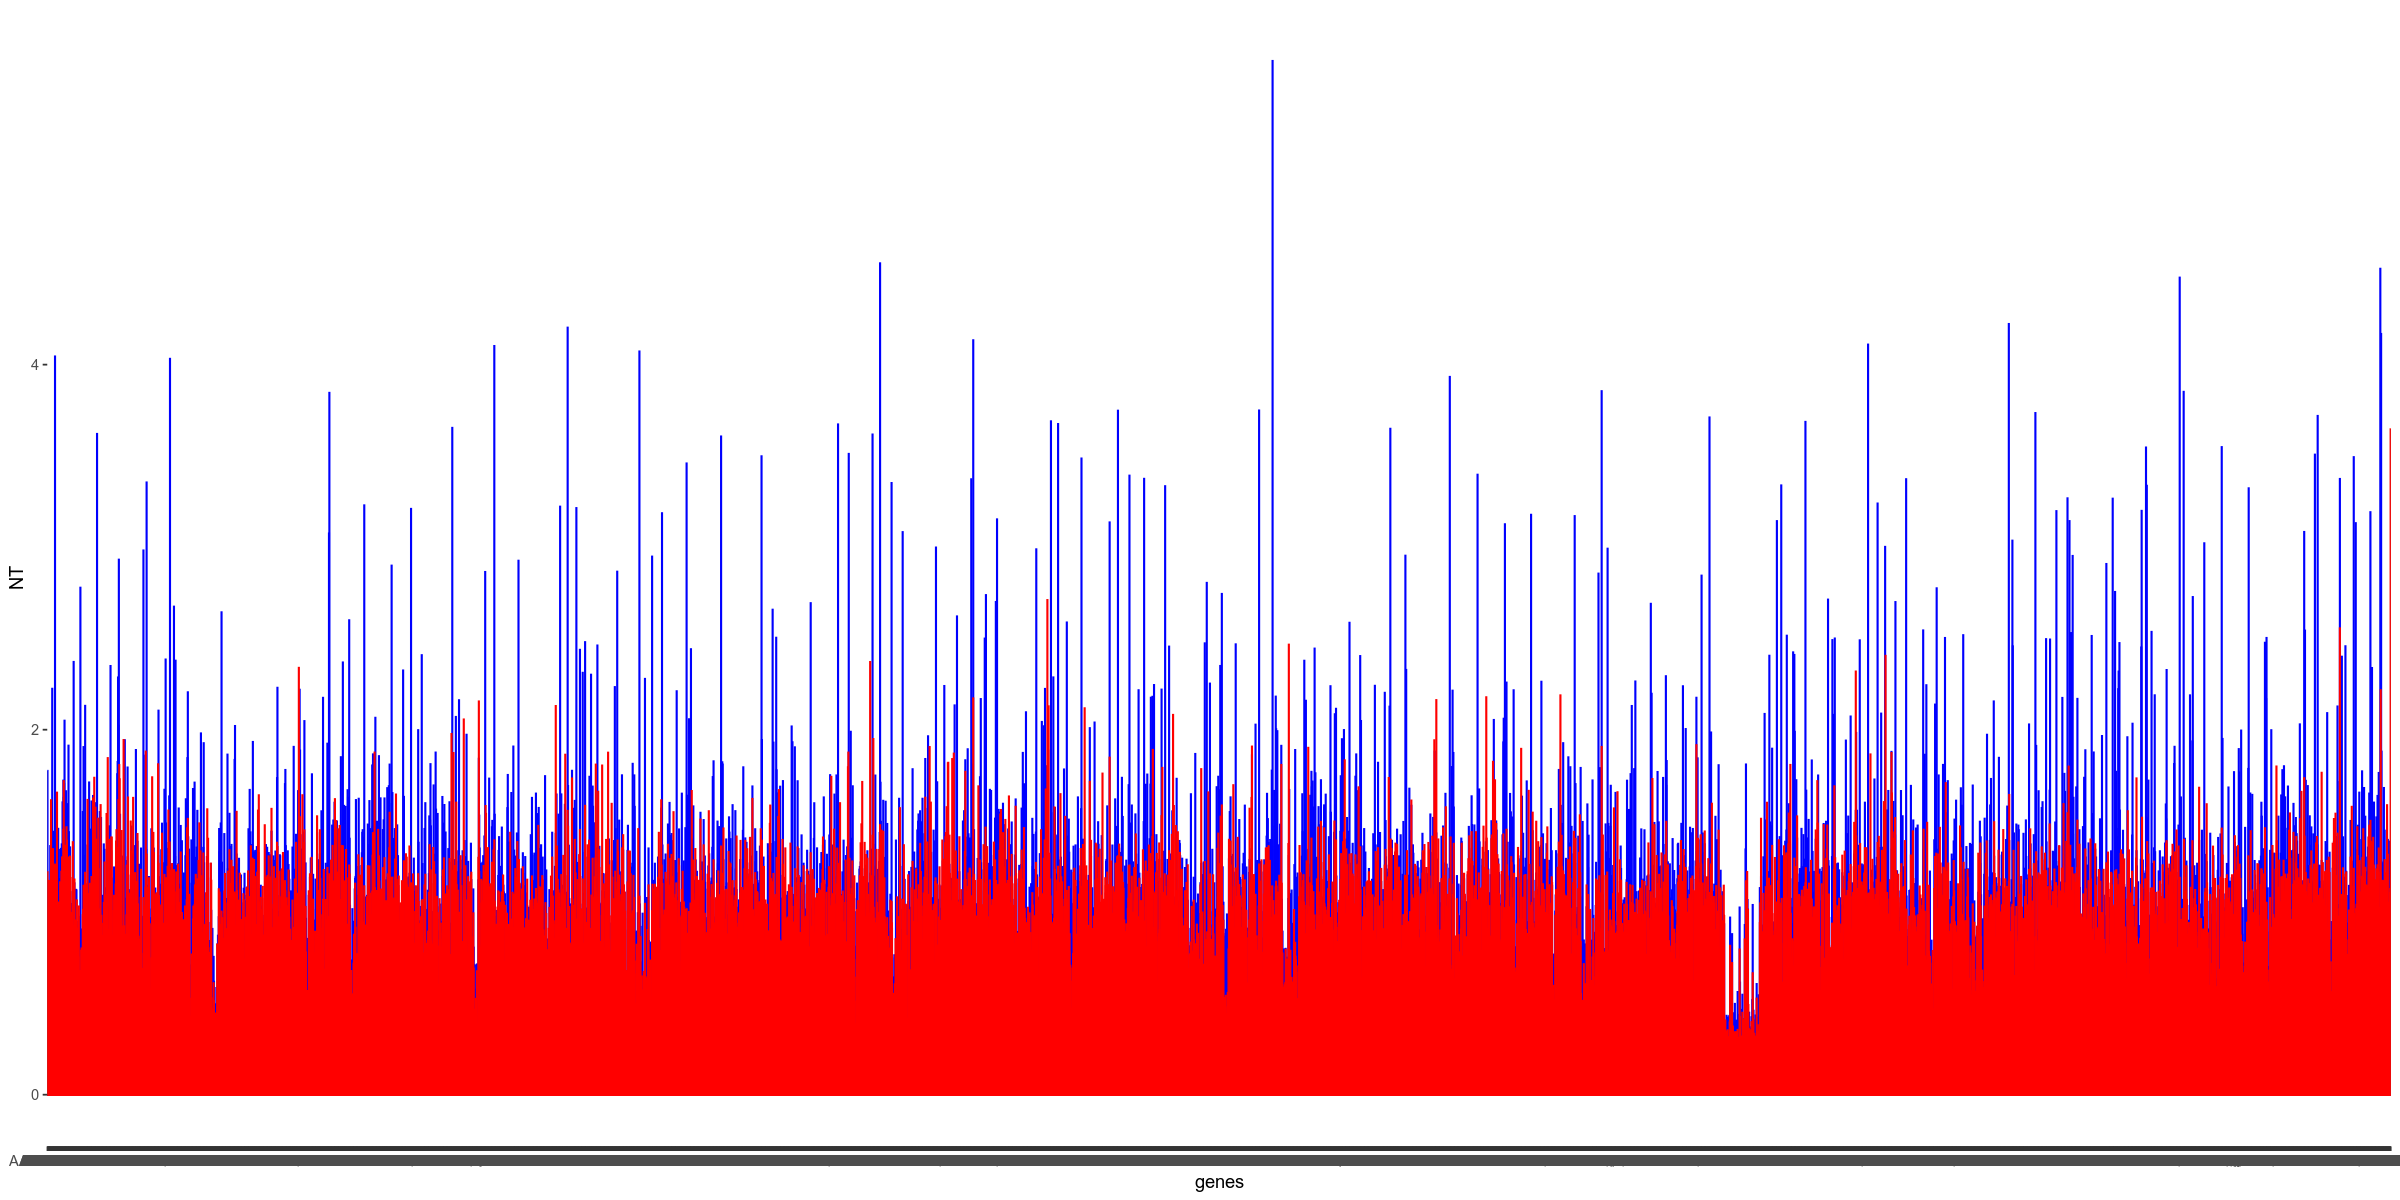

In [ ]:
ggplot(data.frame(genes = rownames(CRISPRi_seurat), NT = CVs[['NT']], MIS18A = CVs[['MIS18A']])) + geom_bar(aes(genes, NT), stat="identity", color = 'blue') + geom_bar(aes(genes, MIS18A), stat="identity", color = 'red')

Warning message:
“Removed 1 rows containing non-finite values (stat_bin).”
Warning message:
“Removed 2 rows containing missing values (geom_bar).”
Warning message:
“Removed 2 rows containing missing values (geom_bar).”


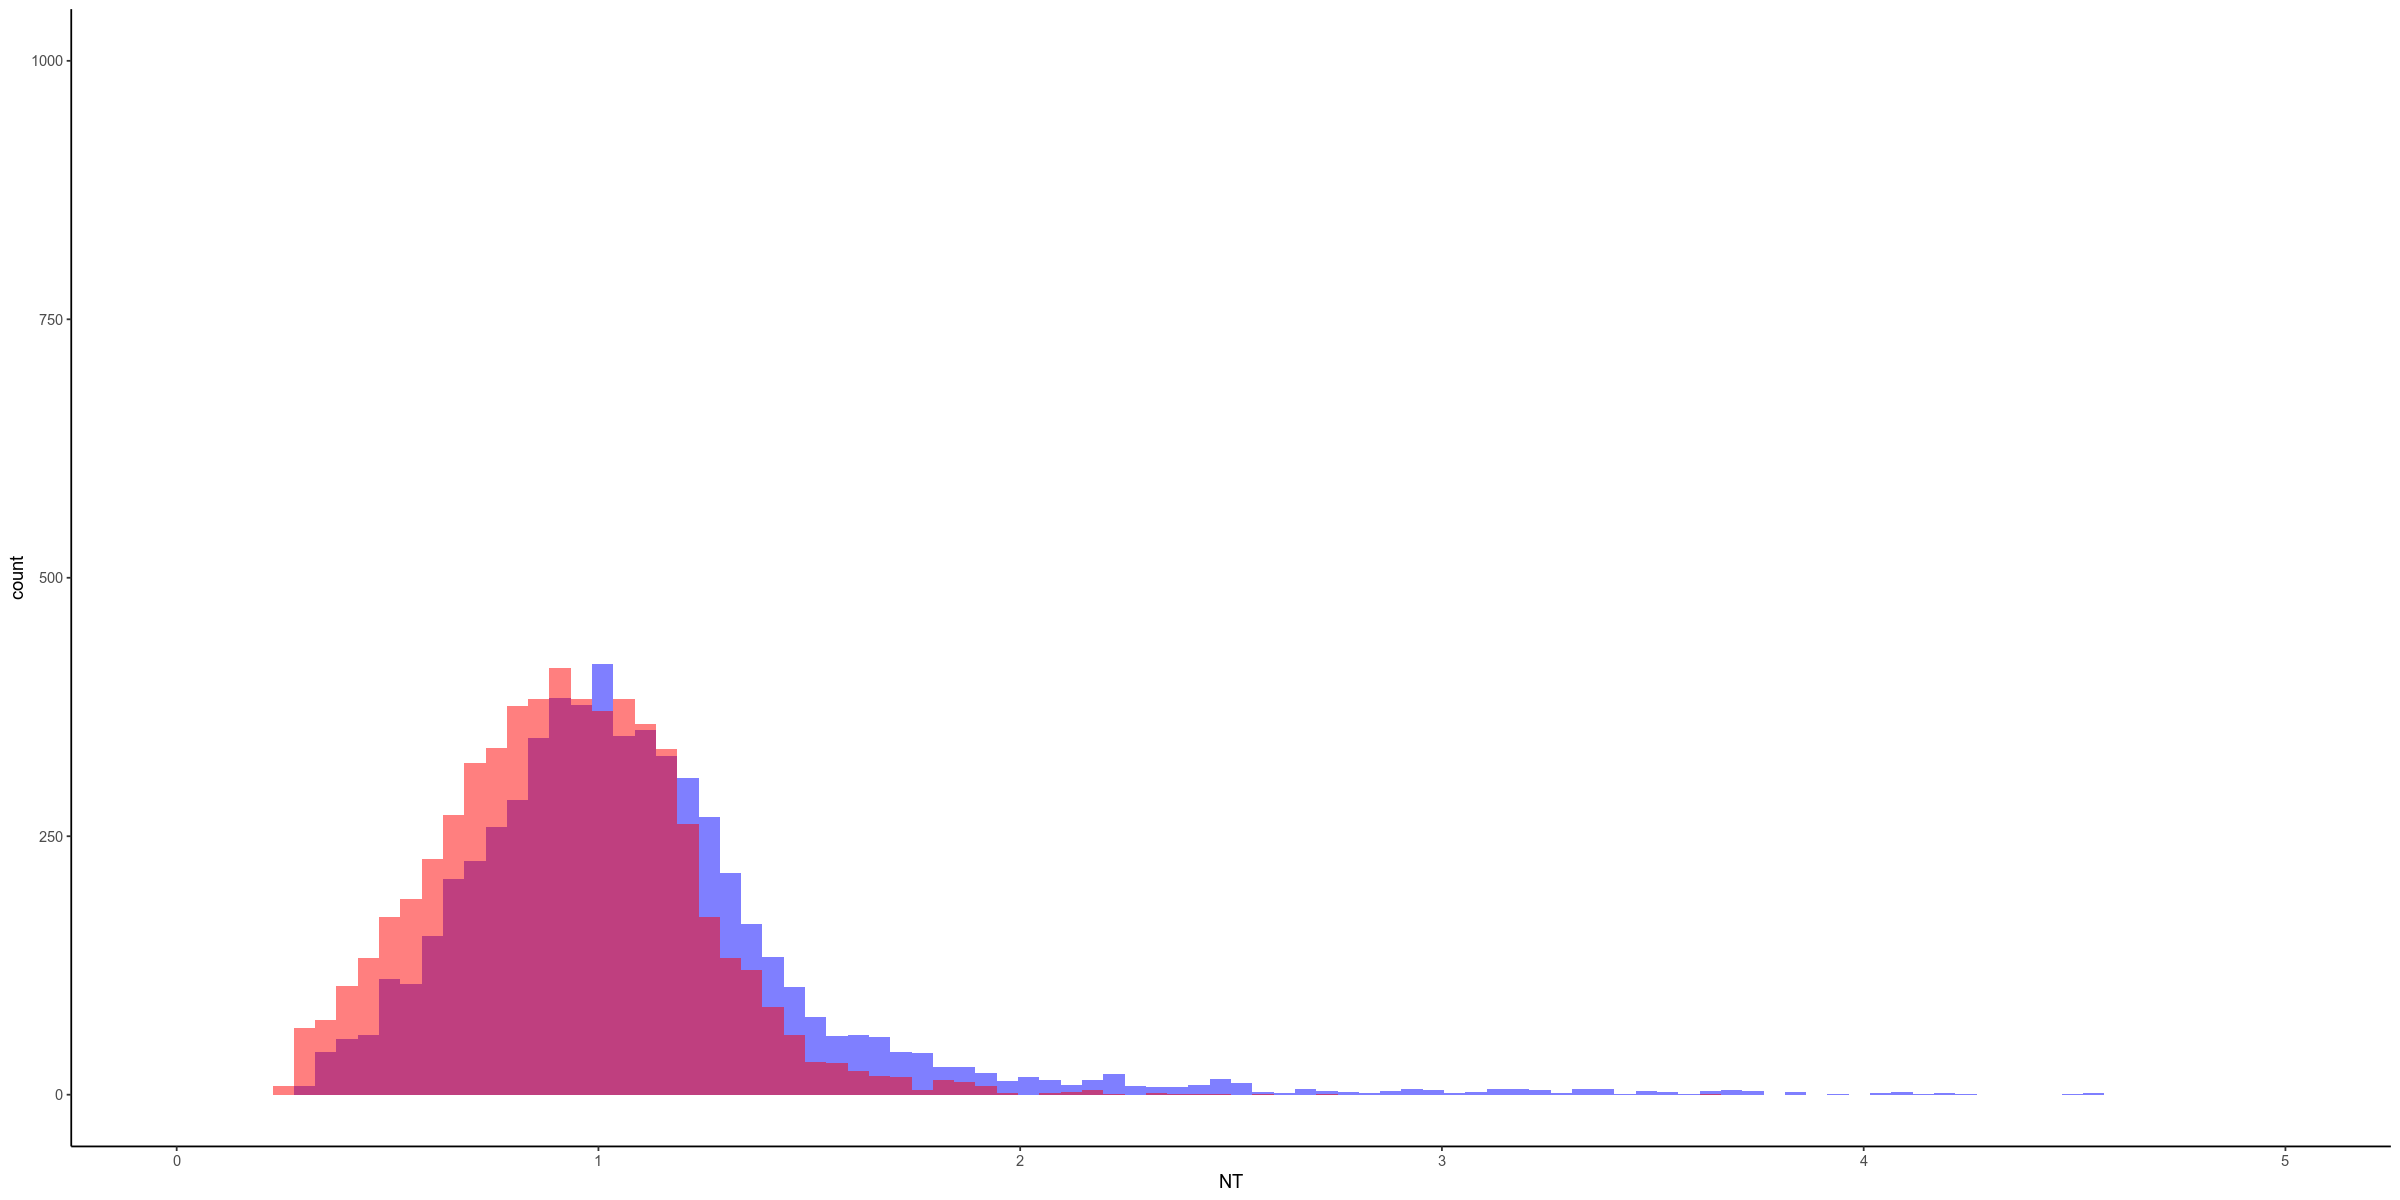

In [ ]:
ggplot(data.frame(NT = CVs[['NT']], MIST18A = CVs[['MIS18A']])) + geom_histogram(aes(x = NT), bins = 100, fill = 'blue', alpha = 0.5) + geom_histogram(aes(x = MIST18A), bins = 100, fill = 'red', alpha = 0.5) + xlim(0, 5) + ylim(0, 1000) + theme_classic()

## Comparing guide mean and NT guide mean ratios

In [55]:
plotted_guides = names(master_df_list)[!(names(master_df_list) %in% c('NT', 'random_NT'))]
plotted_guides_with_NT = names(master_df_list)
ratios = lapply(names(master_df_list), function(x){log2(master_df_list[[x]]$mean_gdmean_ctrlratio)})
names(ratios) = plotted_guides_with_NT
ratios_df <- as.data.frame(do.call(cbind, ratios))
colnames(ratios_df) = names(master_df_list)
ratios_df = ratios_df[, !(colnames(ratios_df) %in% c('NT', 'random_NT'))]
ratios_df = tidyr::pivot_longer(ratios_df, cols = colnames(ratios_df), values_to = 'mean_gdmean_ctrlratio', names_to = 'guide')
ratios_df$guide = factor(ratios_df$guide, levels = order_of_guides)

In [56]:
ratios = ratios[order_of_guides]
tests = lapply(ratios[!endsWith(names(ratios), 'NT')], t.test, mu = 0)
pvals = as.numeric(lapply(tests, function(x) return(x$p.val)))
pvals_adj = signif(p.adjust(pvals), 4)
pvals_adj[pvals_adj == 0] = '< e-300'

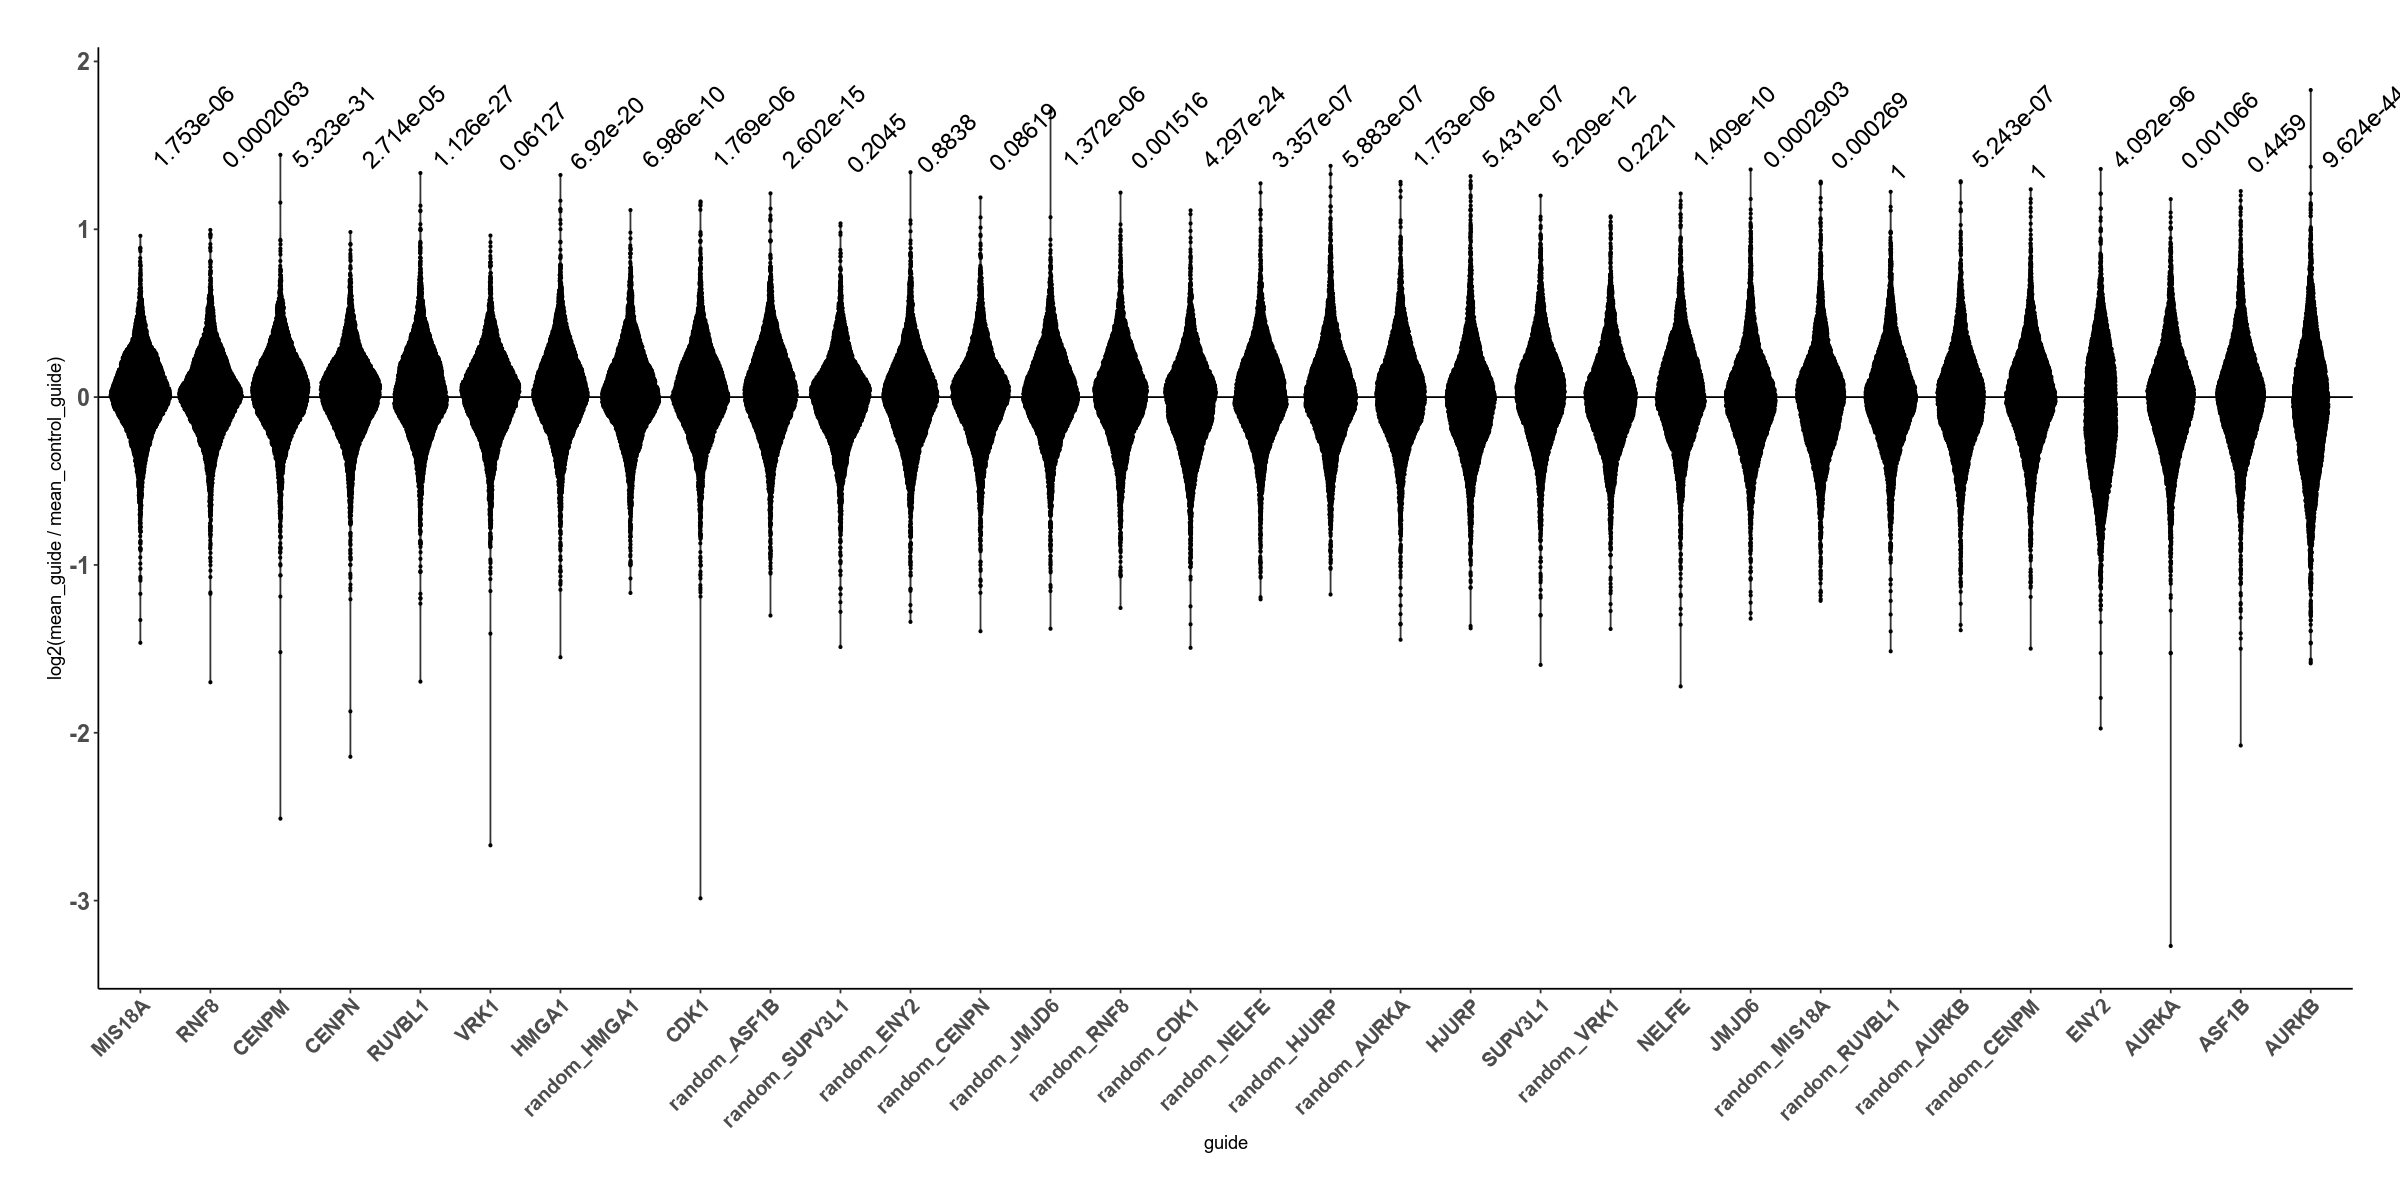

In [57]:
options(repr.plot.width=20, repr.plot.height=10)
library(ggforce)

ggplot(ratios_df, aes(guide, mean_gdmean_ctrlratio, fill = guide)) + ylab('log2(mean_guide / mean_control_guide)') +
  geom_violin(position=position_dodge()) + annotate("text", x = 1:length(plotted_guides), y = 1.3, size = 5, angle='45', hjust = -0.2, label = pvals_adj) +
  geom_sina(position=position_dodge(), size = 0.5) + geom_hline(yintercept = 0) + coord_cartesian(clip = 'off') +
  theme_classic() + theme(plot.margin = margin(1,1,1,1, "cm"), plot.title = element_text(hjust = 0.5), legend.position = 'none', axis.text.y = element_text(face = 'bold', size = 14), axis.text.x = element_text(face = 'bold', size = 12, angle = 45, hjust = 1)) 

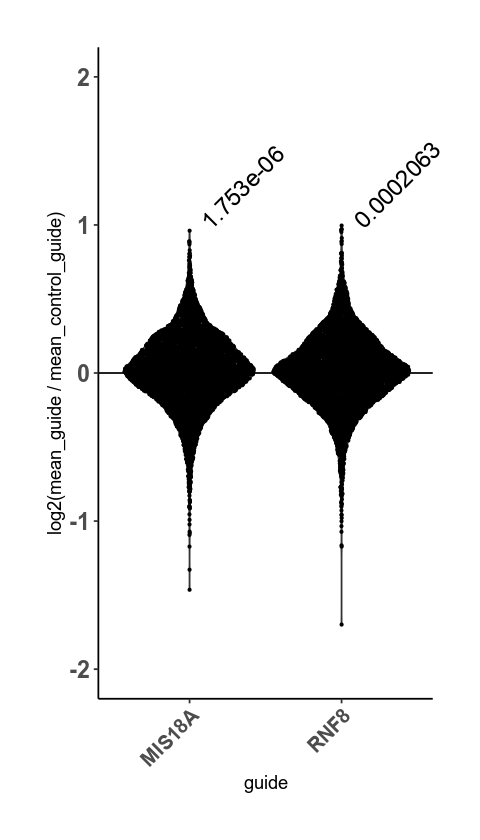

In [60]:
options(repr.plot.width = 4, repr.plot.height = 7)
saveRDS(ratios_df, '/home/ssobti/projects/heterogeneity_brian/fig_output/data/fig3/crispri_single_cell_violin_means_df.rds')
saveRDS(pvals_adj, '/home/ssobti/projects/heterogeneity_brian/fig_output/data/fig3/crispri_single_cell_means_pvals.rds')
saveRDS(ratios, '/home/ssobti/projects/heterogeneity_brian/fig_output/data/fig3/crispri_single_cell_violin_means_ratios.rds')

ratios_df %>% dplyr::filter(guide %in% c('MIS18A', 'RNF8')) %>% ggplot(aes(guide, mean_gdmean_ctrlratio, fill = guide)) + ylab('log2(mean_guide / mean_control_guide)') +
  geom_violin(position=position_dodge()) + annotate("text", x = 1:2, y = 0.9, size = 5, angle='45', hjust = -0.2, label = pvals_adj[names(ratios) %in% c('MIS18A', 'RNF8')][1:2]) +
  geom_sina(position=position_dodge(), size = 0.5) + geom_hline(yintercept = 0) + coord_cartesian(clip = 'off', ylim = c(-2,2)) +
  theme_classic() + theme(plot.margin = margin(1,1,1,1, "cm"), plot.title = element_text(hjust = 0.5), legend.position = 'none', axis.text.y = element_text(face = 'bold', size = 14), axis.text.x = element_text(face = 'bold', size = 12, angle = 45, hjust = 1)) 

In [61]:
ratios_df %>% group_by(guide) %>% summarize(mean = mean(mean_gdmean_ctrlratio)) %>% arrange(mean)

guide,mean
<fct>,<dbl>
ENY2,-0.101059486
AURKB,-0.069475962
random_CDK1,-0.036595930
HJURP,-0.021375043
random_AURKB,-0.021036722
random_MIS18A,-0.016195938
JMJD6,-0.015607243
AURKA,-0.015232727
random_VRK1,-0.007211049


In [ ]:
## Run InferCNV on cells from each guide to show no significant difference in ploidy between guides
## This is to show that the CV differences are not due to ploidy differences between guides

## Counting number of genes that see a significant change in CV from NT control

In [48]:
dim(filtered_raw_mtx)

[1] 5928 7685

In [49]:
## Converting p-values to q-values and adding to master_df_list

for (i in 1:length(master_df_list)){
    q_vals = qvalue(master_df_list[[i]]$p_val, fdr.level = 0.05)
    master_df_list[[i]]$q_val = q_vals$qvalues
}

master_df_list[c('NT', 'random_NT')] <- NULL
guide_subsetted_data[c('NT', 'random_NT')] <- NULL

In [50]:
## ***
## Count number of CV_gdCV_ctrlratio genes > 1 (ie gene_status 'Increasing') with q-val < 0.05
## Count number of CV_gdCV_ctrlratio genes < 1 (ie gene_status 'Decreasing') with q-val < 0.05
filtered_master_df_list = lapply(master_df_list, dplyr::filter, q_val < 0.05)
filtered_mean_shifts_from_NT = lapply(mean_shifts_from_NT, dplyr::filter, p_val_adj < 0.05)
genes_with_shift_in_mean = lapply(filtered_mean_shifts_from_NT, rownames)

## remove genes that see significant change in mean from NT from increase/decrease counts in filtered_master_df_list

for (i in 1:length(filtered_master_df_list)){
    if (length(genes_with_shift_in_mean[[i]]) > 0){
        intersection = intersect(genes_with_shift_in_mean[[i]], filtered_master_df_list[[i]]$gene)
        if (length(intersection) > 0){
            filtered_master_df_list[[i]] = filtered_master_df_list[[i]][!(filtered_master_df_list[[1]]$gene %in% intersection),]
        }
    }
}

## counting genes with change in CV

gene_status_list = lapply(filtered_master_df_list, '[[', 'gene_status')

count_increasing = function(x){length(which(x == 'Increasing'))}
count_decreasing = function(x){length(which(x == 'Decreasing'))}

number_of_increasing_CV_genes = sapply(gene_status_list, count_increasing)
number_of_decreasing_CV_genes = sapply(gene_status_list, count_decreasing)

metric_change_df = data.frame(guide = names(master_df_list), increasing_CV_genes = number_of_increasing_CV_genes, decreasing_CV_genes = number_of_decreasing_CV_genes)

In [51]:
## z-score each guide by the following formula:
## (# of genes increased CV in guide - mean(# of genes increased CV bkg))/sd(# of genes increased CV bkg)
## (# of genes decreased CV in guide - mean(# of genes decreased CV bkg))/sd(# of genes decreased CV bkg)

increasing_random_vals = metric_change_df$increasing_CV_genes[startsWith(rownames(metric_change_df), 'random')]
metric_change_df$z_score_increasing_genes = (metric_change_df$increasing_CV_genes - mean(increasing_random_vals)) / sd(increasing_random_vals)

decreasing_random_vals = metric_change_df$decreasing_CV_genes[startsWith(rownames(metric_change_df), 'random')]
metric_change_df$z_score_decreasing_genes = (metric_change_df$decreasing_CV_genes - mean(decreasing_random_vals)) / sd(decreasing_random_vals)

In [52]:
path = paste0('/home/ssobti/projects/heterogeneity_brian/output_data/CRISPRi_CRISPRa_cell_culture_screen/heterogeneity/', variant, 'metric_change_df.csv')
write.csv(metric_change_df, file = path)

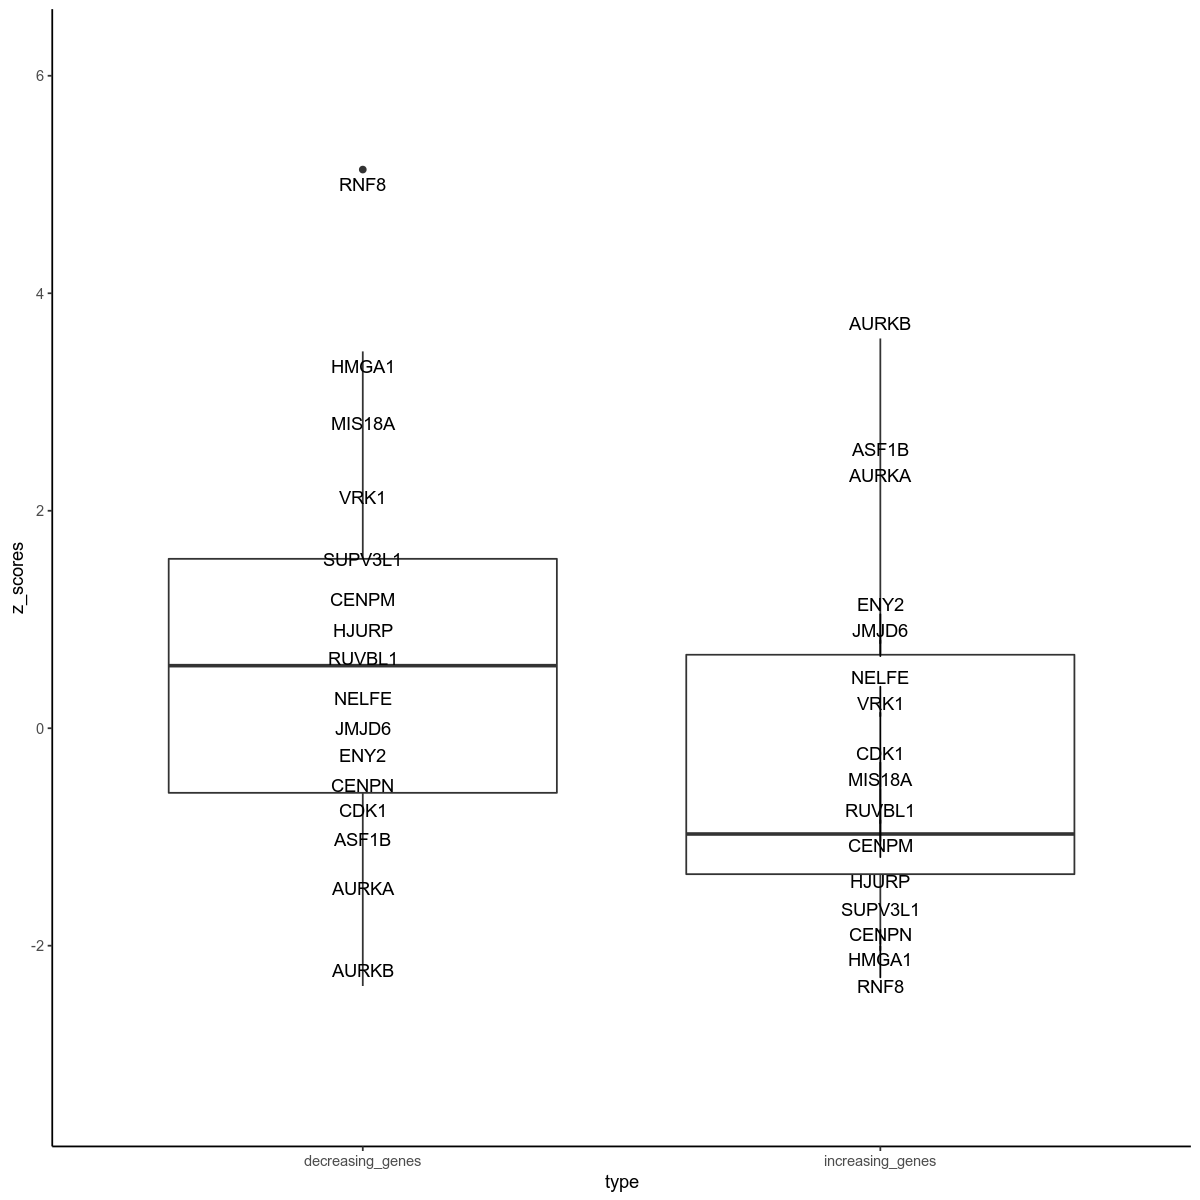

In [53]:
## graph z-scores of increasing CV of each of the guides as boxplot, show top ones. Also show z-scores of decreasing CV
options(repr.plot.width=10, repr.plot.height=10)
graphing_z_score_df = metric_change_df[!startsWith(rownames(metric_change_df), 'random'),]
graphing_z_score_df = tidyr::pivot_longer(graphing_z_score_df, cols = starts_with("z_score"), names_to = "type", names_prefix = "z_score_", values_to = "z_scores")
graphing_z_score_df = as.data.frame(graphing_z_score_df)
path = paste0('/home/ssobti/projects/heterogeneity_brian/output_data/CRISPRi_CRISPRa_cell_culture_screen/heterogeneity/', variant, 'graphing_z_score_df.csv')
write.csv(graphing_z_score_df, file = path)
graphing_z_score_df = read.csv(path)

library(ggplot2)
library(ggrepel)

ggplot(graphing_z_score_df, aes(x=type, y=z_scores)) + 
    geom_boxplot() + scale_fill_brewer(palette="Blues") + geom_text_repel(aes(y = z_scores, x = type, label = guide), direction = "y") +
    theme_classic() + ylim(min(graphing_z_score_df$z_scores) - 1, max(graphing_z_score_df$z_scores) + 1)

In [54]:
metric_change_df$number_of_increasing_CV_genes_minus_random = metric_change_df$increasing_CV_genes - mean(increasing_random_vals)
metric_change_df$number_of_decreasing_CV_genes_minus_random = metric_change_df$decreasing_CV_genes - mean(decreasing_random_vals)
metric_change_df$number_of_net_decreasing_CV_genes = metric_change_df$number_of_decreasing_CV_genes_minus_random - metric_change_df$number_of_increasing_CV_genes_minus_random

In [55]:
graphing_gene_numbers_df = metric_change_df[!startsWith(rownames(metric_change_df), 'random'),]
graphing_gene_numbers_df = tidyr::pivot_longer(graphing_gene_numbers_df, cols = starts_with("number"), names_to = "type", names_prefix = "number_of_", values_to = "number_of_genes")
graphing_gene_numbers_df = as.data.frame(graphing_gene_numbers_df)

png 
  2

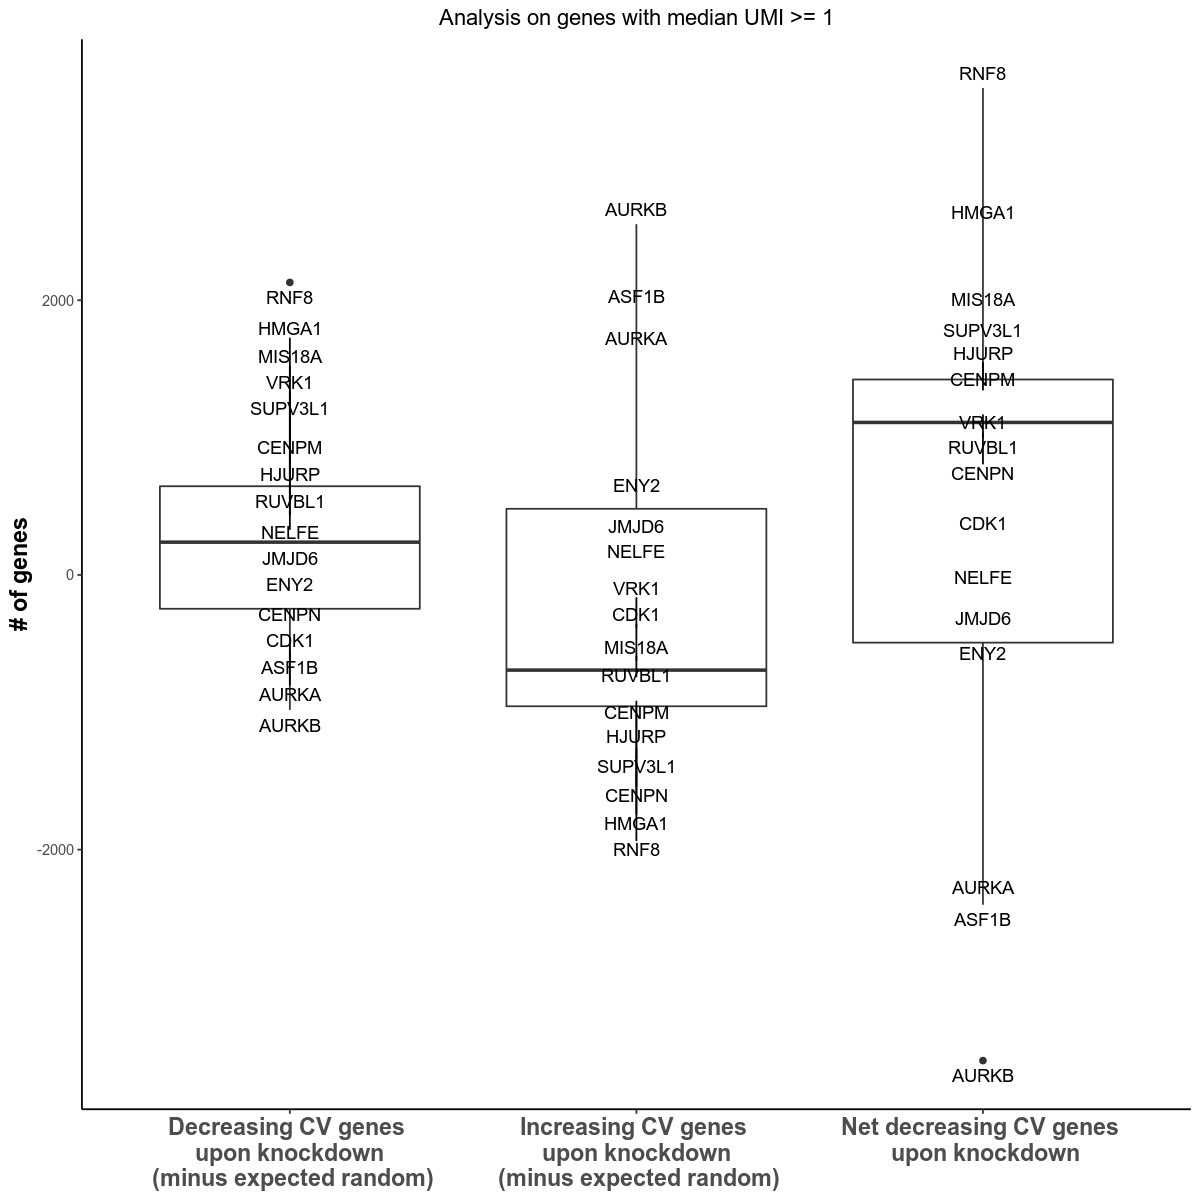

In [56]:
options(repr.plot.width=10, repr.plot.height=10)
ggplot(graphing_gene_numbers_df, aes(x=type, y=number_of_genes)) + ggtitle('Analysis on genes with median UMI >= 1') +
    geom_boxplot() + scale_fill_brewer(palette="Blues") + geom_text_repel(aes(y = number_of_genes, x = type, label = guide), direction = "y") +
    scale_x_discrete(labels=c("Decreasing CV genes \n upon knockdown \n (minus expected random)", 
                              "Increasing CV genes \n upon knockdown \n (minus expected random)", 
                              "Net decreasing CV genes \n upon knockdown")) + ylab('# of genes') +
    theme_classic() + theme(axis.title.x=element_blank(), axis.text.x = element_text(size = 14, face = 'bold'), axis.title.y = element_text(size = 14, face = 'bold'), plot.title = element_text(hjust = 0.5))

path = paste0('/home/ssobti/projects/heterogeneity_brian/output_data/CRISPRi_CRISPRa_cell_culture_screen/heterogeneity/', variant, 'gene_shifts.pdf')

pdf(path, width = 10, height = 10)
ggplot(graphing_gene_numbers_df, aes(x=type, y=number_of_genes)) + ggtitle('Analysis on genes with median UMI >= 1') +
    geom_boxplot() + scale_fill_brewer(palette="Blues") + geom_text_repel(aes(y = number_of_genes, x = type, label = guide), direction = "y") +
    scale_x_discrete(labels=c("Decreasing CV genes \n upon knockdown \n (minus expected random)", 
                              "Increasing CV genes \n upon knockdown \n (minus expected random)", 
                              "Net decreasing CV genes \n upon knockdown")) + ylab('# of genes') +
    theme_classic() + theme(axis.title.x=element_blank(), axis.text.x = element_text(size = 14, face = 'bold'), axis.title.y = element_text(size = 14, face = 'bold'), plot.title = element_text(hjust = 0.5))
dev.off()


In [57]:
cells_analyzed = lapply(guide_subsetted_data[1:16], colnames)
cells_analyzed = as.character(unlist(cells_analyzed))

In [58]:
correlation_df = filtered_meta_data[cells_analyzed,] %>% group_by(guide) %>% summarize(nFeatures_RNA = mean(nFeature_RNA), nCount_RNA = mean(nCount_RNA), mito = mean(percent.mt))
rownames(correlation_df) = correlation_df$guide
correlation_df = as.data.frame(correlation_df)
net_decreasers = graphing_gene_numbers_df %>% filter(type == 'decreasing_CV_genes_minus_random') %>% select(guide, number_of_genes)
names(net_decreasers)[names(net_decreasers) == 'number_of_genes'] <- 'number_of_genes_decreasing_CV'
correlation_df = full_join(correlation_df, net_decreasers, by = 'guide')
net_decreasers = graphing_gene_numbers_df %>% filter(type == 'increasing_CV_genes_minus_random') %>% select(guide, number_of_genes)
names(net_decreasers)[names(net_decreasers) == 'number_of_genes'] <- 'number_of_genes_increasing_CV'
correlation_df = full_join(correlation_df, net_decreasers, by = 'guide')
net_decreasers = graphing_gene_numbers_df %>% filter(type == 'net_decreasing_CV_genes') %>% select(guide, number_of_genes)
names(net_decreasers)[names(net_decreasers) == 'number_of_genes'] <- 'number_of_genes_net_decreasing_CV'
correlation_df = full_join(correlation_df, net_decreasers, by = 'guide')
names(correlation_df)[names(correlation_df) == 'guide'] <- 'guide_name'
correlation_df = full_join(correlation_df, filter(cell_gd_count, guide_name != 'NT'), by = 'guide_name')

Warning message:
“Setting row names on a tibble is deprecated.”


In [59]:
cor(correlation_df[,-1])

,nFeatures_RNA,nCount_RNA,mito,number_of_genes_decreasing_CV,number_of_genes_increasing_CV,number_of_genes_net_decreasing_CV,cell_count
nFeatures_RNA,1.0000000,0.8615804,0.2961183,0.8828723,-0.8861074,0.9465528,0.6720391
nCount_RNA,0.8615804,1.0000000,-0.1390044,0.7992639,-0.6209681,0.7393379,0.5619947
mito,0.2961183,-0.1390044,1.0000000,0.0906676,-0.4534101,0.3323342,0.1877067
number_of_genes_decreasing_CV,0.8828723,0.7992639,0.0906676,1.0000000,-0.7357020,0.8982786,0.7510909
number_of_genes_increasing_CV,-0.8861074,-0.6209681,-0.4534101,-0.7357020,1.0000000,-0.9584912,-0.4177274
number_of_genes_net_decreasing_CV,0.9465528,0.7393379,0.3323342,0.8982786,-0.9584912,1.0000000,0.5871989
cell_count,0.6720391,0.5619947,0.1877067,0.7510909,-0.4177274,0.5871989,1.0000000


In [ ]:
## remove genes with change in mean as seen from t-test

In [32]:
## most importantly see which guides have high z-scores in first graph and low in second 
## also which guides have low z-scores in first graph and high in second 

In [33]:
### the next step could be a comparison between control cells
## and each guide vs comparison between control cells and guides grouped by seed sequence
## analagous to comparing magnitude of CV influence from q25/q75 analysis to q10/q90